In [1]:
import numpy as np
import random
import itertools as it
import os, subprocess
import time

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mycolorpy import colorlist as mcp
import seaborn as sns

from UQpy.distributions import Normal, Uniform, JointIndependent
from UQpy.surrogates import *
from UQpy.sensitivity import *
from UQpy.sampling import LatinHypercubeSampling
from UQpy.sampling.stratified_sampling.latin_hypercube_criteria import *

from UQpy.utilities.kernels.GaussianKernel import GaussianKernel
from UQpy.dimension_reduction.diffusion_maps.DiffusionMaps import DiffusionMaps as DiffusionMapsUQ

from sklearn.model_selection import train_test_split

import scipy
from scipy.integrate import odeint

from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps

import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol

import proplot as pplt

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.1
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

pplt.rc['grid.linewidth'] = 0.1
pplt.rc['grid.alpha'] = 0.3

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")


In [2]:
class GDMaps:
    """
    Performs GDMaps for a given dataset.
    n_evecs must be greater than n_parsim
    """

    def __init__(self, data, n_evecs, n_parsim, p, verbose=False):
        self.data = data
        self.n_evecs = n_evecs
        self.n_parsim = n_parsim
        self.p = p
        self.verbose = verbose

    def get(self):
        Gr = Grassmann(distance_method=Grassmann.grassmann_distance, kernel_method=Grassmann.projection_kernel,
                       karcher_method=Grassmann.gradient_descent)
        Gr.manifold(p=self.p, samples=self.data)

        dfm = DiffusionMaps(alpha=0.5, n_evecs=self.n_evecs + 1, kernel_object=Gr, kernel_grassmann='prod')
        g, evals, evecs = dfm.mapping()

        # Parsimonious representation: index - the eigenvectors indices; 
        # Residuals used to identify the most parsimonious low-dimensional representation.
        index, residuals = dfm.parsimonious(num_eigenvectors=self.n_evecs, visualization=False)

        coord = index[1:self.n_parsim + 1]

        g_k = g[:, coord]

        # g_k = g[:, 1:]  # without parsimonious
        # coord = np.arange(1, g_k.shape[1]+1)  # diffusion coordinates numbers

        print('Grassmann projection rank is: ', Gr.p)

        return g_k, coord, Gr, residuals, index, evals, evecs

In [3]:
class PceModel:
    """
    Constructs a PCE surrogate on the Grassmannian diffusion manifold.
    """

    def __init__(self, x, g, dist_obj, max_degree, verbose=False):
        self.x = x
        self.g = g
        self.dist_obj = dist_obj
        self.max_degree = max_degree
        self.verbose = verbose

    def get(self):

        # Polynomial basis
        polynomial_basis = TotalDegreeBasis(distributions=self.dist_obj, max_degree=self.max_degree)
        least_squares = LeastSquareRegression()
        pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

        x_train, x_test, \
        g_train, g_test = train_test_split(self.x, self.g, train_size=2 / 3, random_state=1)
        
        # Fit model
        pce.fit(x_train, g_train)
        
        print('Size of the full set of PCE basis:', pce.polynomial_basis.polynomials_number)
        print('Shape of the training set (x)):', x_train.shape)
        print('Shape of the training set (y)):', g_train.shape)

        error_val = ErrorEstimation(surr_object=pce).validation(x_test, g_test)

        if self.verbose:
            # Plot accuracy of PCE
            if os.path.exists('pce_accuracy'):
                command = ['rm', '-r', 'pce_accuracy']
                subprocess.run(command)

            command = ['mkdir', 'pce_accuracy']
            subprocess.run(command)

            print(g_test[0, :])
            print(pce.predict(x_test)[0, :])

            for i in range(5):
                r = random.randint(0, x_test.shape[0])
                plt.figure()
                plt.plot(g_test[r, :], 'b-o', label='true')
                plt.plot(pce.predict(x_test)[r, :], 'r-*', label='pce')
                plt.legend()
                plt.savefig('pce_accuracy/pce_{}.png'.format(i), bbox_inches='tight')

        return pce, error_val

In [4]:
class ErrorEstimation:
    """
    Class for estimating the error of a PCE surrogate, based on a validation
    dataset.

    **Inputs:**

    * **surr_object** ('class'):
        Object that defines the surrogate model.

    **Methods:**
    """

    def __init__(self, surr_object):
        self.surr_object = surr_object

    def validation(self, x, y):
        """
        Returns the validation error.

        **Inputs:**

        * **x** (`ndarray`):
            `ndarray` containing the samples of the validation dataset.

        * **y** (`ndarray`):
            `ndarray` containing model evaluations for the validation dataset.

        **Outputs:**

        * **eps_val** (`float`)
            Validation error.

        """
        if y.ndim == 1 or y.shape[1] == 1:
            y = y.reshape(-1, 1)

        y_val = self.surr_object.predict(x)

        n_samples = x.shape[0]
        mu_yval = (1 / n_samples) * np.sum(y, axis=0)
        eps_val = (n_samples - 1) / n_samples * (
                (np.sum((y - y_val) ** 2, axis=0)) / (np.sum((y - mu_yval) ** 2, axis=0)))

        if y.ndim == 1 or y.shape[1] == 1:
            eps_val = float(eps_val)

        return np.round(eps_val, 7)
    

# 1. Lottka-Volterra example:

The classic Lotka-Volterra dynamical system, also known as the predator- prey equations, an example of a Kolmogorov model which describes the dynamics of a biological system in which two species interact, a predator (e.g., foxes) and a prey (e.g., rabbits).

$$\frac{du}{dt} = \alpha u − \beta uv$$
$$\frac{dv}{dt} =\delta uv−\gamma v$$

where $u$ is the prey population, $v$ is the predator population and $\alpha,\beta,\gamma,\delta$ are stochastic model parameters: 


- Population of prey species: $u, u(t = 0) = 10$

- Population of predator species: $v,  v(t = 0) = 5$

- Natural growing rate of preys when no predator exists: $\alpha \sim U(0.90,1)$

- Natural dying rate of preys due to predation: $\beta \sim U (0.10, 0.15)$

- Natural dying rate of predator when no prey exists $\gamma = 1.50$ 

- Reproduction rate of predators per prey eaten $\delta = 0.75$

In [5]:
def Lotka_Voltera(a, b, c, d, t):
    
    X_f0 = np.array([     0. ,  0.])

    def dX_dt(X, t=0):
        """ Return the growth rate of fox and rabbit populations. """
        return np.array([ a*X[0] -   b*X[0]*X[1] ,  
                      -c*X[1] + d*b*X[0]*X[1] ])
    
    # Initials conditions: 10 rabbits and 5 foxes  
    X0 = np.array([10, 5]) 

    X, infodict = scipy.integrate.odeint(dX_dt, X0, t, full_output=True)
    
    return X

In [51]:
n_samples = 600

# Probability distributions of input parameters
pdf1 = Uniform(loc=0.9, scale=0.15)  # a 
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
c = 1.5
d = 0.75

margs = [pdf1, pdf2]
joint = JointIndependent(marginals=margs)

# Draw samples: input
x = joint.rvs(n_samples)

n = 512 #2178
n2 = 2*n
# time steps
t = np.linspace(0, 25,  n) 

out = []

for i in range(x.shape[0]):
    out_ = Lotka_Voltera(x[i, 0], x[i, 1], c, d, t)
    out_ = out_.T.flatten() # keep both species
    out.append(out_)

data = np.array(out)
data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [52]:
len(list(data))

600

In [53]:
print('Input array (x):')
print(x)

Input array (x):
[[0.96478411 0.13457862]
 [0.99695102 0.17466645]
 [1.04079298 0.14163536]
 ...
 [0.91892007 0.12908393]
 [1.047181   0.16130329]
 [0.98463465 0.17941468]]


In [54]:
print('Initial shape of the output array:')
print(np.asarray(out).shape)

Initial shape of the output array:
(600, 1024)


In [55]:
print('The shape of the output array after reshaping:')
print(data.shape)

The shape of the output array after reshaping:
(600, 32, 32)


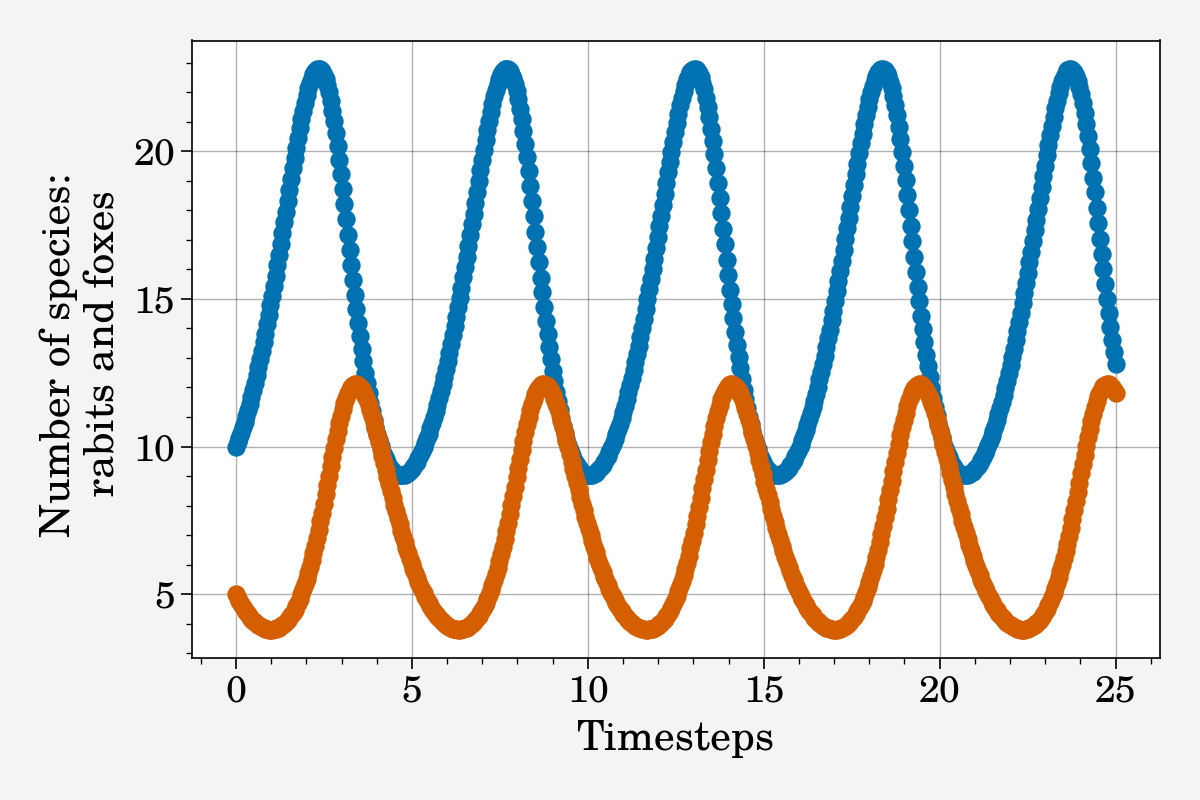

In [56]:
plt.scatter(t, out[0][:n])
plt.scatter(t, out[0][n:])
plt.xlabel('Timesteps')
plt.ylabel('Number of species: \n rabits and foxes')
plt.tight_layout()
plt.show()

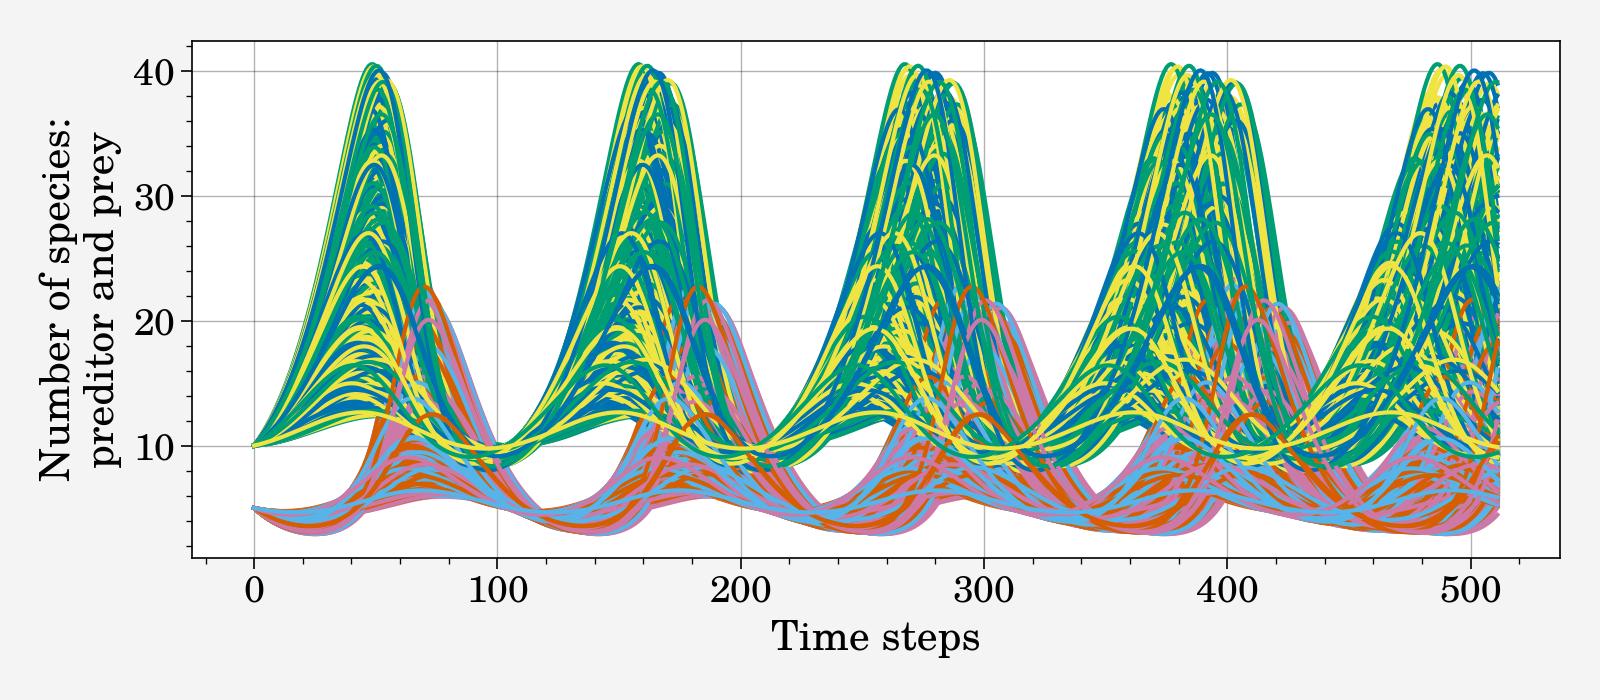

In [57]:
fix, ax = plt.subplots(figsize=(8, 3.5))
for i in range(np.asarray(out).shape[0]):
    ax.plot(out[i][:n])
    ax.plot(out[i][n:])
ax.set_xlabel('Time steps')
ax.set_ylabel('Number of species:\npreditor and prey')
plt.tight_layout()
plt.savefig('plots/LV_600.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
ranks = [np.linalg.matrix_rank(data[i]) for i in range(len(data))]
unique, counts = np.unique(ranks, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 31   1]
 [ 32 599]]


Grassmann projection rank is:  10
Size of the full set of PCE basis: 28
Shape of the training set (x)): (400, 2)
Shape of the training set (y)): (400, 3)
[ 0.00876157 -0.00088341 -0.00012169]
[ 0.00855232 -0.00037692  0.00024649]
Error of PCE: [0.0086189 0.0219436 0.1265537]
--- Surrogate - 21.103785276412964 seconds ---


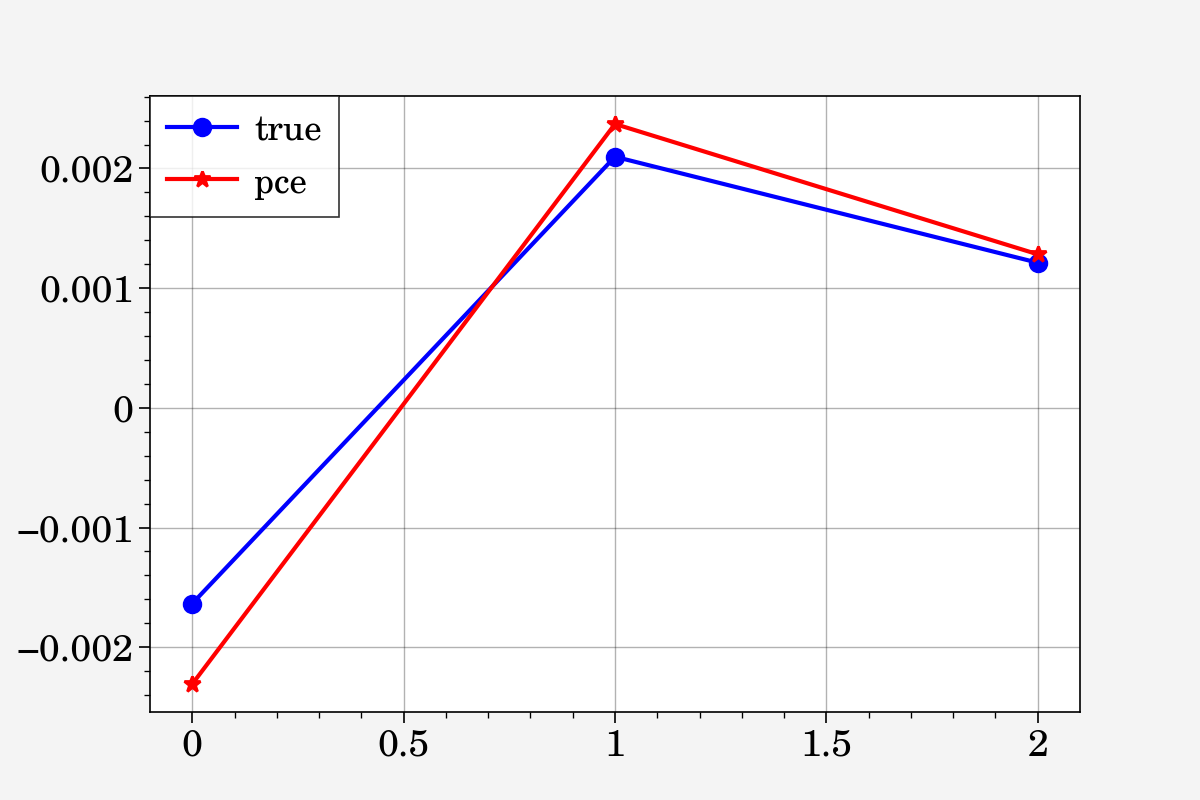

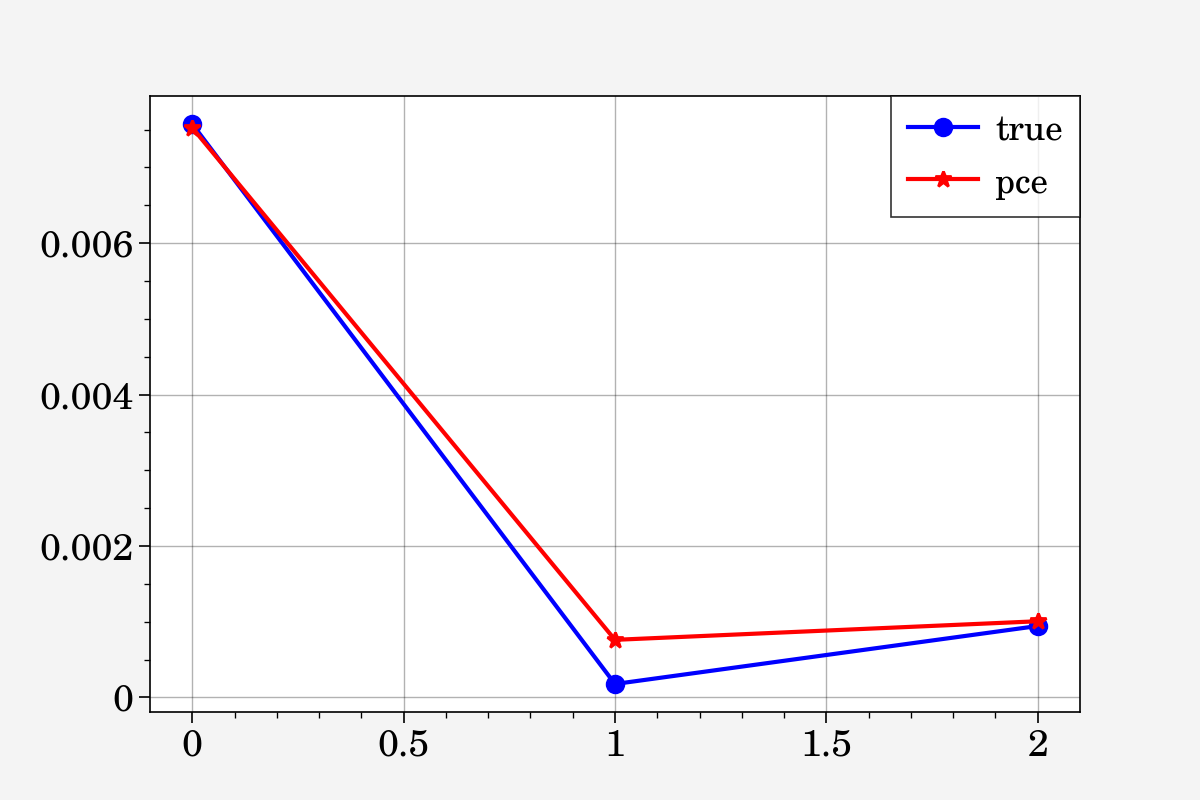

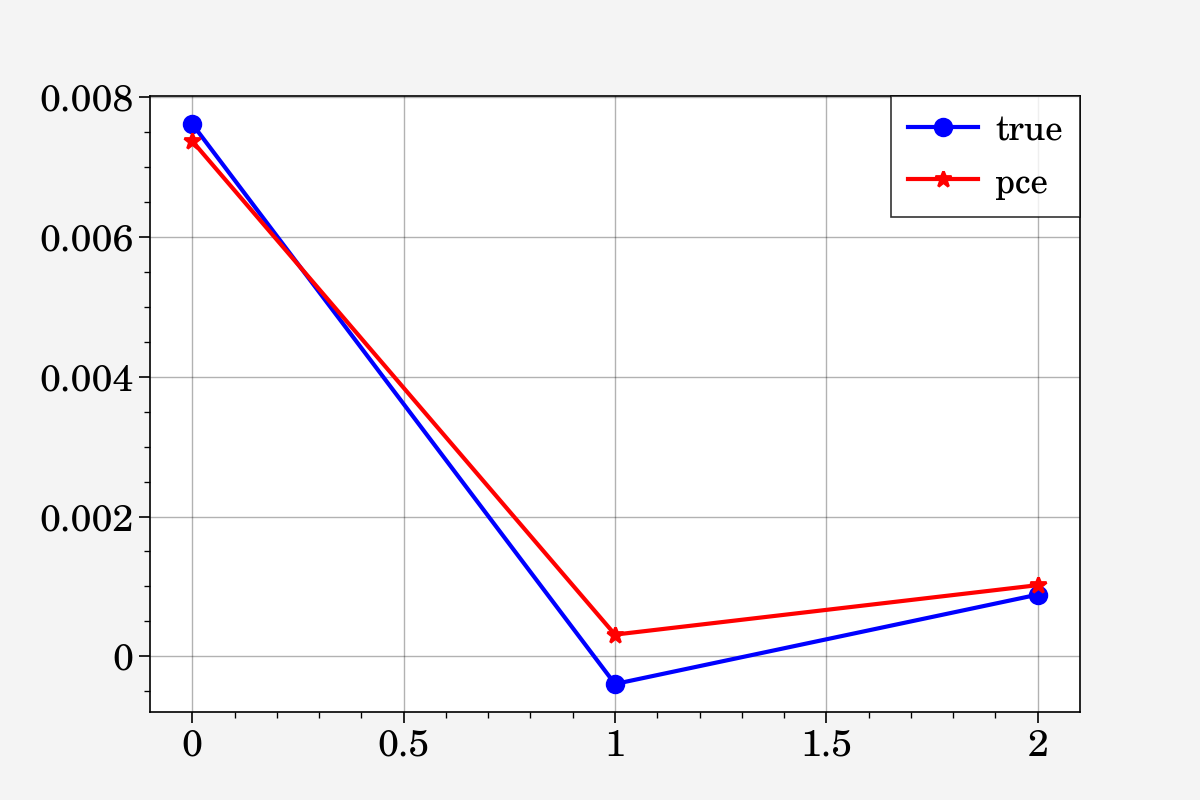

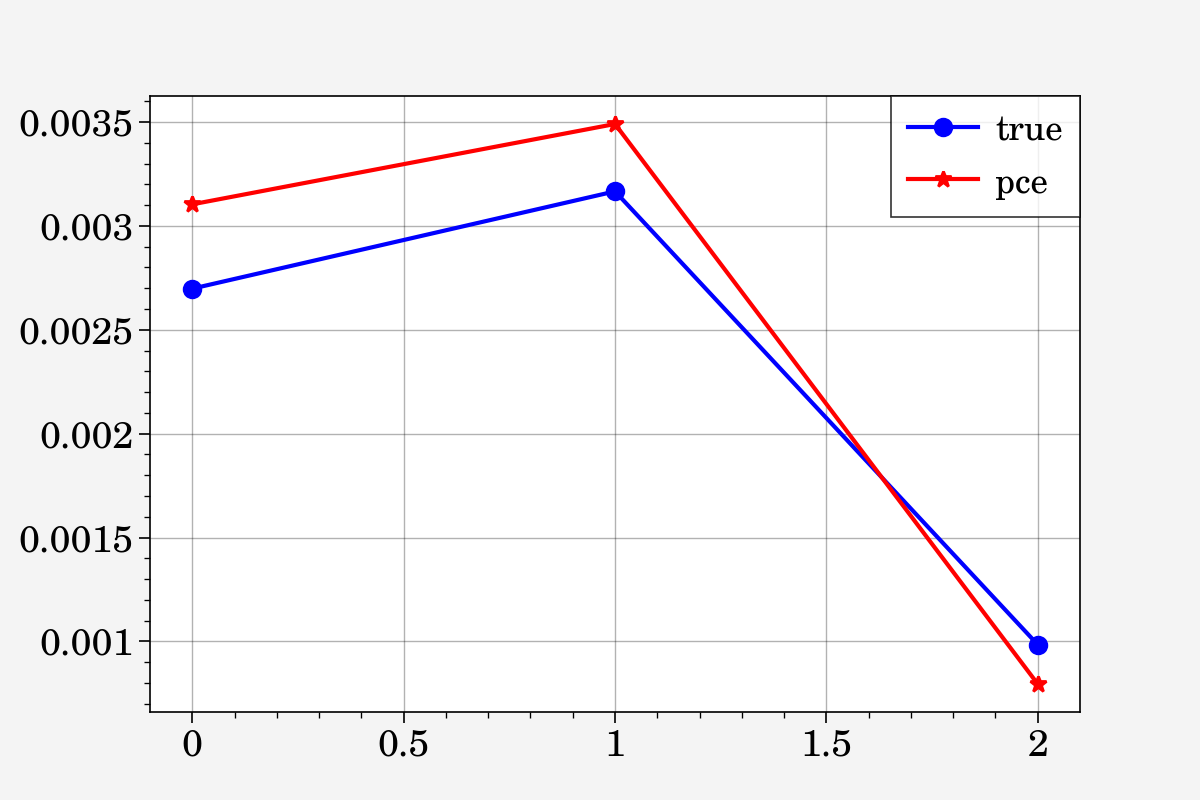

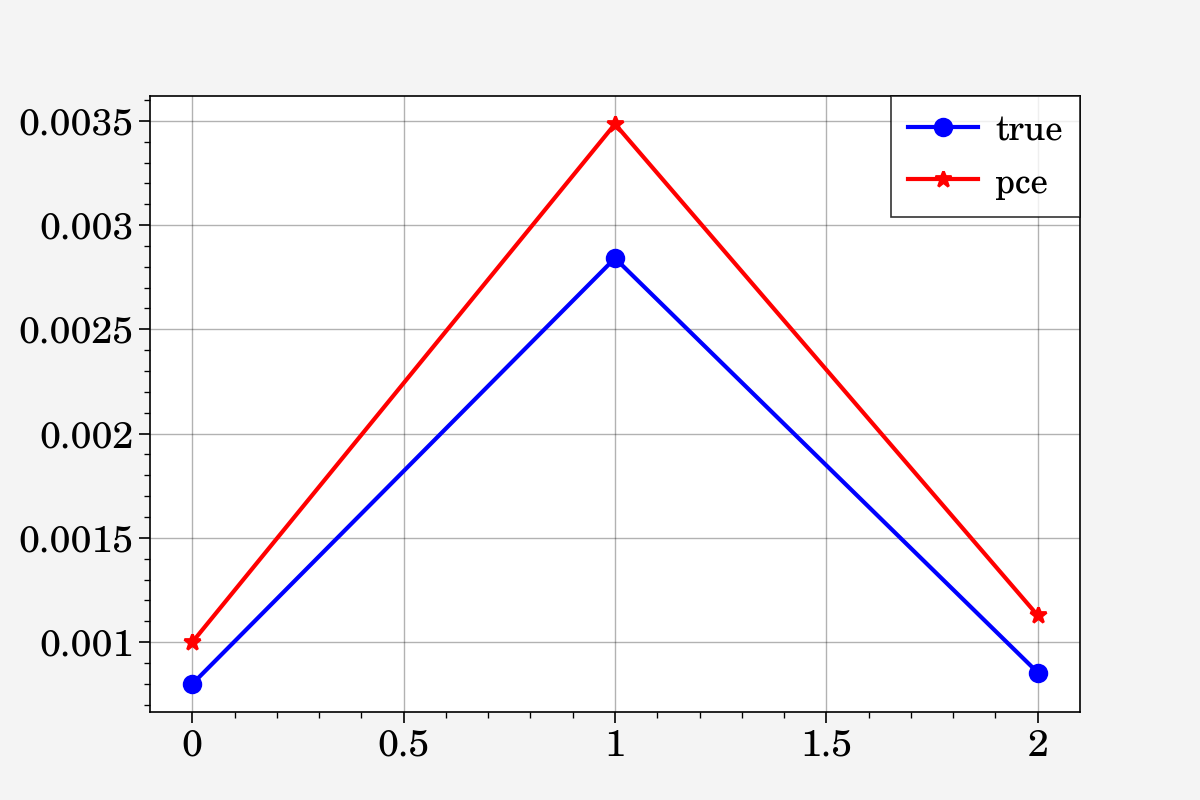

In [59]:
start_time = time.time()

# Perform GDMAps
g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                         n_evecs=20,
                                                         n_parsim=3, 
                                                         p=10).get() 
# Perform PCE on the manifold
pce, error = PceModel(x=x, 
                      g=g, 
                      dist_obj=joint, 
                      max_degree=6, 
                      verbose=True).get()

print('Error of PCE:', error)
print("--- Surrogate - %s seconds ---" % (time.time() - start_time))


In [64]:
x.shape

(600, 2)

In [61]:
g.shape

(600, 3)

In [62]:
pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()

In [63]:
pce_to_si

array([[0.63309148, 0.87474839, 0.53210267],
       [0.47721793, 0.84176901, 0.56211847]])

In [15]:
np.asarray(Grass.phi).shape

(600, 32, 10)

In [16]:
ranks = [np.linalg.matrix_rank(data[i]) for i in range(len(data))]

In [17]:
max(ranks)

32

In [18]:
# investigate further p and consider verification 

## GDMaps outputs:

In [19]:
print('Diffusion coordinates (shape):')
print(g.shape)

Diffusion coordinates (shape):
(600, 3)


In [20]:
# coord = index[1:self.n_parsim + 1]
print('Coordinates trucated:')
print(coord)

Coordinates trucated:
[1 2 5]


In [21]:
# Grass: DimensionReduction.Grassmann object with:
# distance_method=Grassmann.grassmann_distance
# kernel_method=Grassmann.projection_kernel,
# karcher_method=Grassmann.gradient_descent

In [22]:
print('Residuals: used to identify the most parsimonious low-dimensional representation')
print(residuals)

Residuals: used to identify the most parsimonious low-dimensional representation
[       nan 1.         0.61499491 0.17315003 0.1574672  0.18009303
 0.12597566 0.138406   0.10609206 0.05738279 0.08078005 0.11199825
 0.07921145 0.07139046 0.04072306 0.07386835 0.05879385 0.03927828
 0.04328398 0.03808548]


In [23]:
print('Indices of the eigenvalues associated with each residual:')
print(index)

Indices of the eigenvalues associated with each residual:
[ 0  1  2  5  3  4  7  6 11  8 10 12 15 13 16  9 18 14 17 19]


In [24]:
print('Eigenvalues from DiffusionMaps.mapping():')
print(evals)

Eigenvalues from DiffusionMaps.mapping():
[1.         0.18083879 0.08182984 0.04467017 0.03949572 0.02626316
 0.01911545 0.01387114 0.01036883 0.00844693 0.00655509 0.0059613
 0.00483278 0.00475189 0.00418457 0.00378716 0.00342562 0.00322901
 0.00295256 0.00261416 0.00244164]


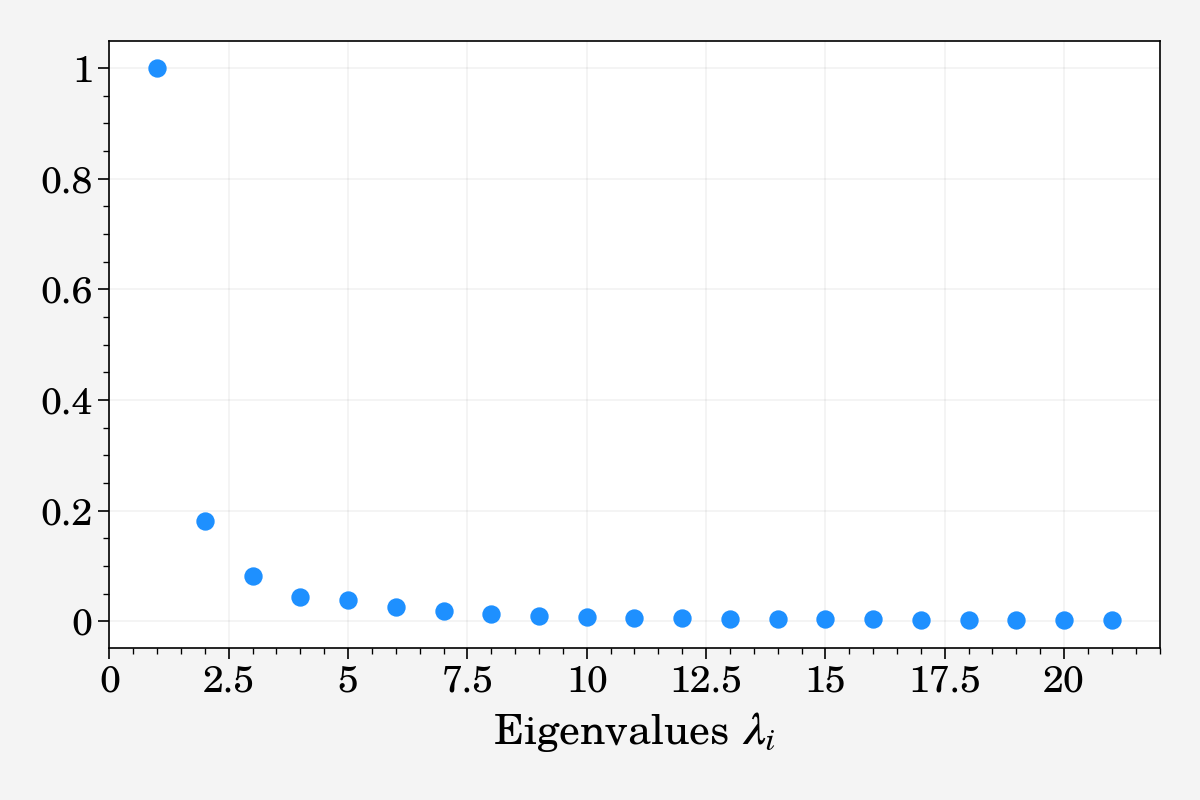

In [25]:
plt.scatter(np.arange(1, len(evals)+1, 1), evals, c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$')
plt.tight_layout()
plt.show()

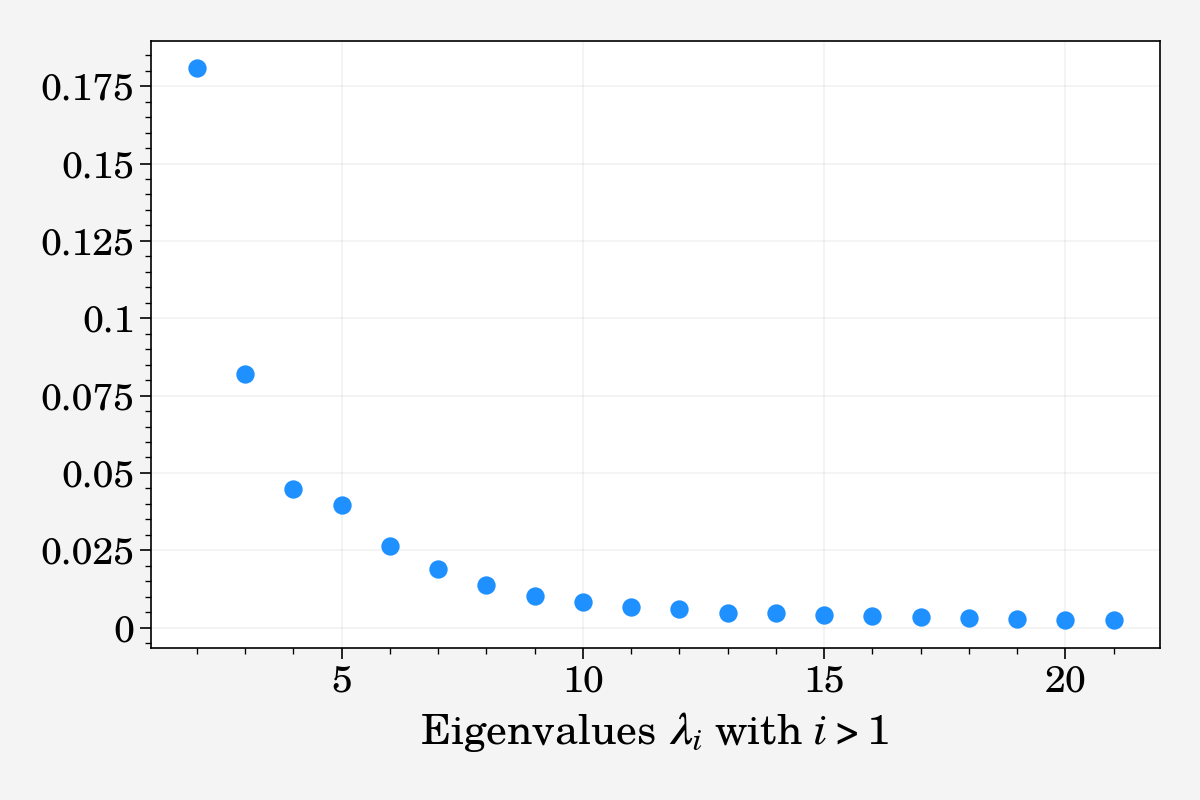

In [26]:
plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
plt.tight_layout()
plt.show()

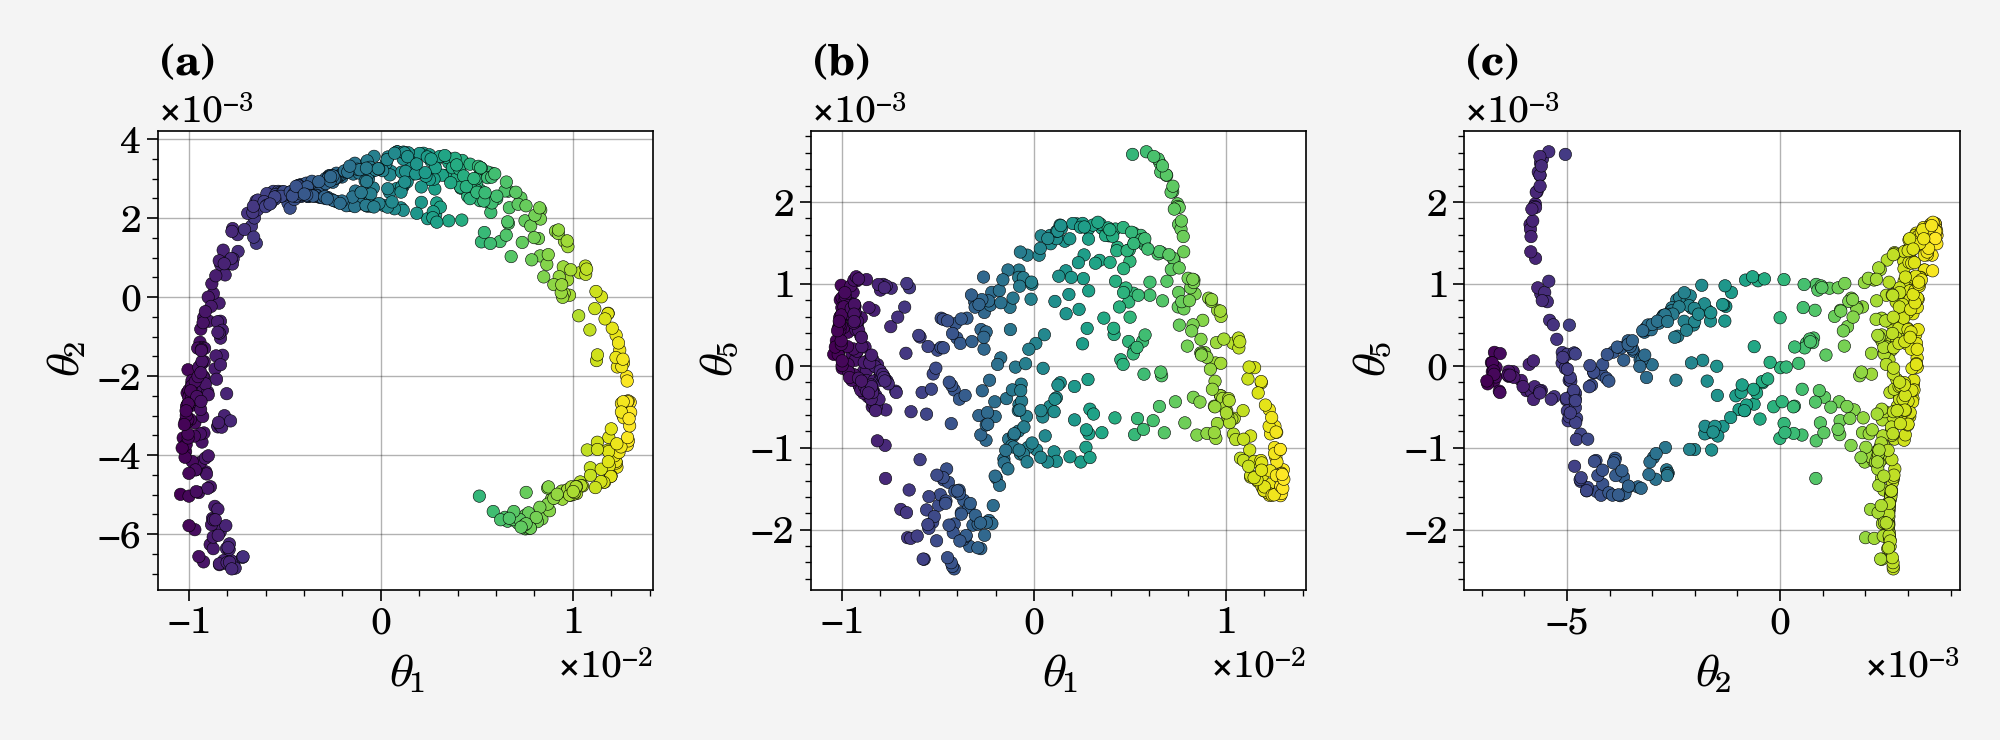

In [27]:
# Plotting diffusion coordinates

pplt.rc['grid.linewidth'] = 0.5
pplt.rc['grid.alpha'] = 0.3

numbering= ['(a)', '(b)', '(c)']

comb1 = list(it.combinations(list(coord), 2))
comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

# Plot first three plots
if coord.shape[0] > 2:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.7), constrained_layout=True)
    for i in range(len(comb1)):
        ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                      cmap='viridis', s=20, 
                      edgecolors='k', 
                      linewidth=0.2)
        ax[i].set_xlabel(r'$\theta_{}$'.format(comb1[i][0]))
        ax[i].set_ylabel(r'$\theta_{}$'.format(comb1[i][1]))
        ax[i].grid('True')
        ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        ax[i].set_title(r'$\bf{{{}}}$'.format(numbering[i]), loc='left', pad=20)
    fig.tight_layout()
    plt.savefig('plots/LV_2vars_PCE_dcoords.png', dpi=300, bbox_inches='tight')
    plt.show()
    

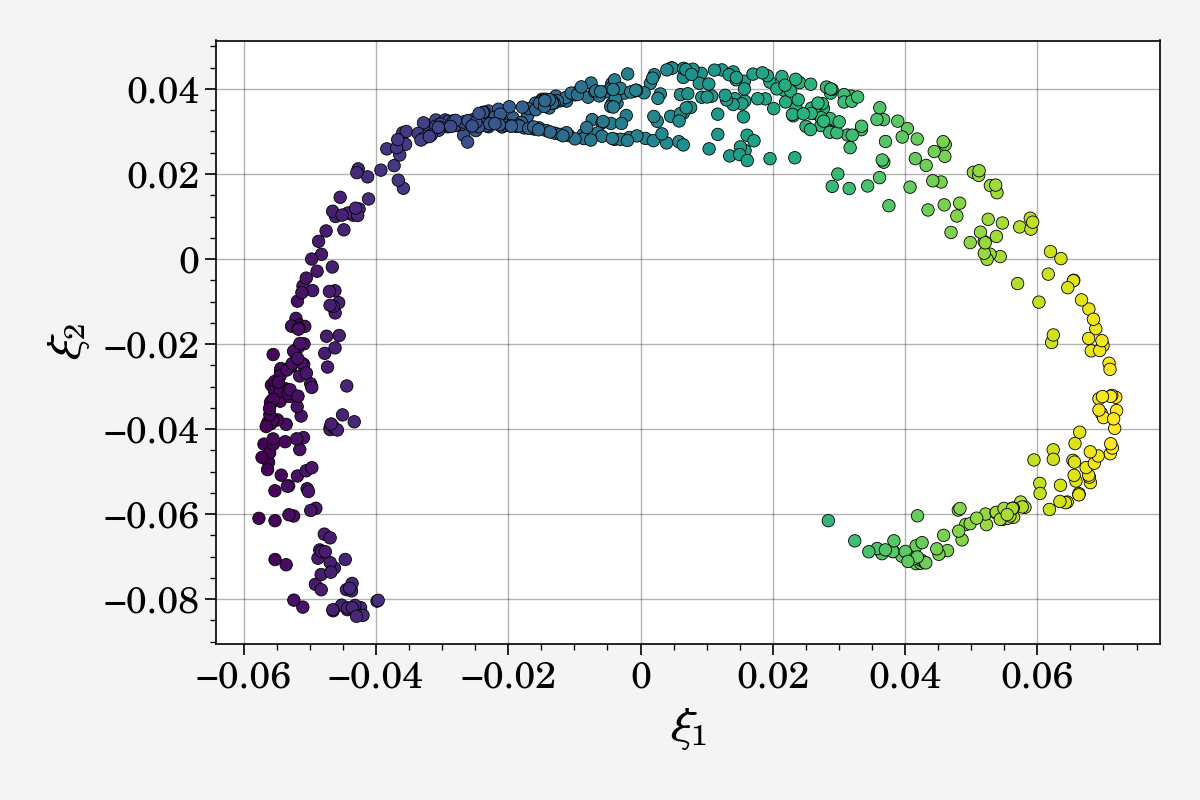

In [28]:
# Plotting eigenvectors
plt.scatter(evecs[:, 1], evecs[:, 2], c=evecs[:, 1],
            cmap='viridis', s=20, 
            edgecolors='k', 
            linewidth=0.3)
plt.xlabel(r'$\xi_{1}$')
plt.ylabel(r'$\xi_{2}$')
plt.tight_layout()
plt.show()

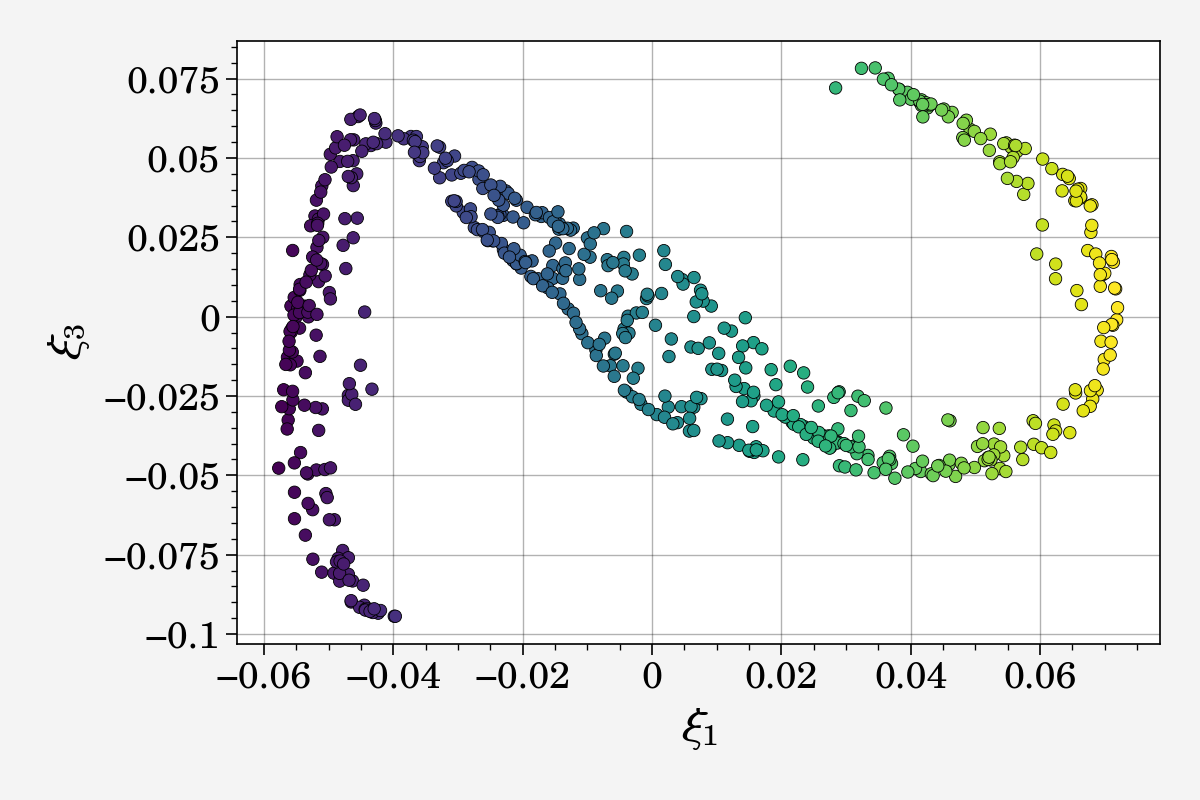

In [29]:
# Plotting eigenvectors
plt.scatter(evecs[:, 1], evecs[:, 3], c=evecs[:, 1],
            cmap='viridis', s=20, 
            edgecolors='k', 
            linewidth=0.3)
plt.xlabel(r'$\xi_{1}$')
plt.ylabel(r'$\xi_{3}$') 
plt.tight_layout()
plt.show()

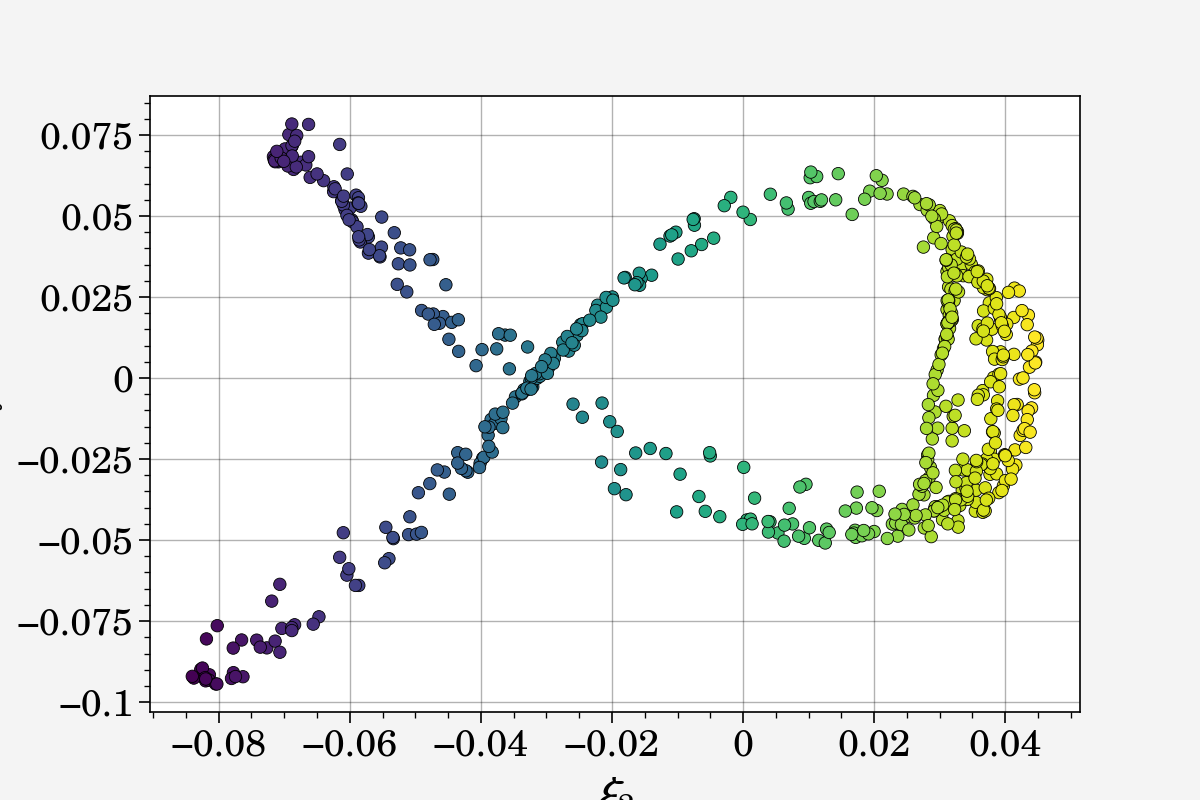

In [30]:
# Plotting eigenvectors
plt.scatter(evecs[:, 2], evecs[:, 3], c=evecs[:, 2],
            cmap='viridis', s=20, 
            edgecolors='k', 
            linewidth=0.3)
plt.xlabel(r'$\xi_{2}$')
plt.ylabel(r'$\xi_{3}$')        
plt.show()

# put into 3d plot

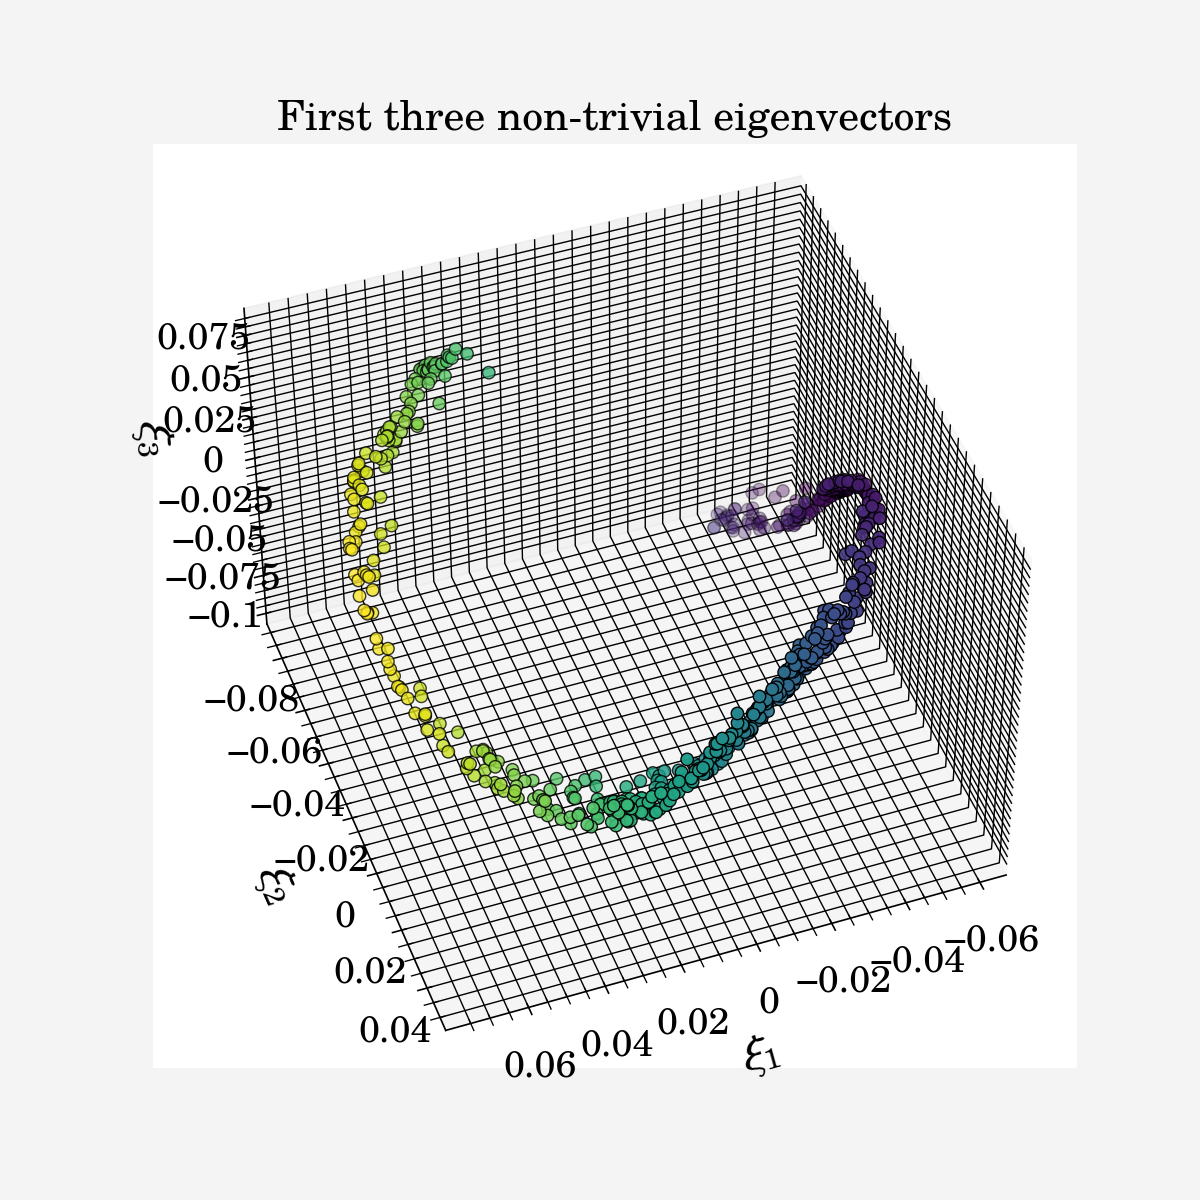

In [31]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(evecs[:, 1], evecs[:, 2], evecs[:, 3],
           cmap='viridis', s=20,
           c=evecs[:, 1],
           edgecolors='k', 
           linewidth=0.5)
ax.set(xlabel=r'$\xi_{1}$', 
       ylabel=r'$\xi_{2}$', 
       zlabel=r'$\xi_{3}$', 
       title='First three non-trivial eigenvectors')
ax.view_init(45, 70)
plt.show()

## PceModel outputs:

Grassmann projection rank is:  10
Size of the full set of PCE basis: 28
Shape of the training set (x)): (341, 2)
Shape of the training set (y)): (341, 3)
Grassmann projection rank is:  10
Size of the full set of PCE basis: 28
Shape of the training set (x)): (341, 2)
Shape of the training set (y)): (341, 3)
Grassmann projection rank is:  10
Size of the full set of PCE basis: 28
Shape of the training set (x)): (341, 2)
Shape of the training set (y)): (341, 3)
Grassmann projection rank is:  10
Size of the full set of PCE basis: 28
Shape of the training set (x)): (341, 2)
Shape of the training set (y)): (341, 3)
Grassmann projection rank is:  10
Size of the full set of PCE basis: 28
Shape of the training set (x)): (341, 2)
Shape of the training set (y)): (341, 3)
Grassmann projection rank is:  10
Size of the full set of PCE basis: 28
Shape of the training set (x)): (341, 2)
Shape of the training set (y)): (341, 3)
Grassmann projection rank is:  10
Size of the full set of PCE basis: 28
Shap

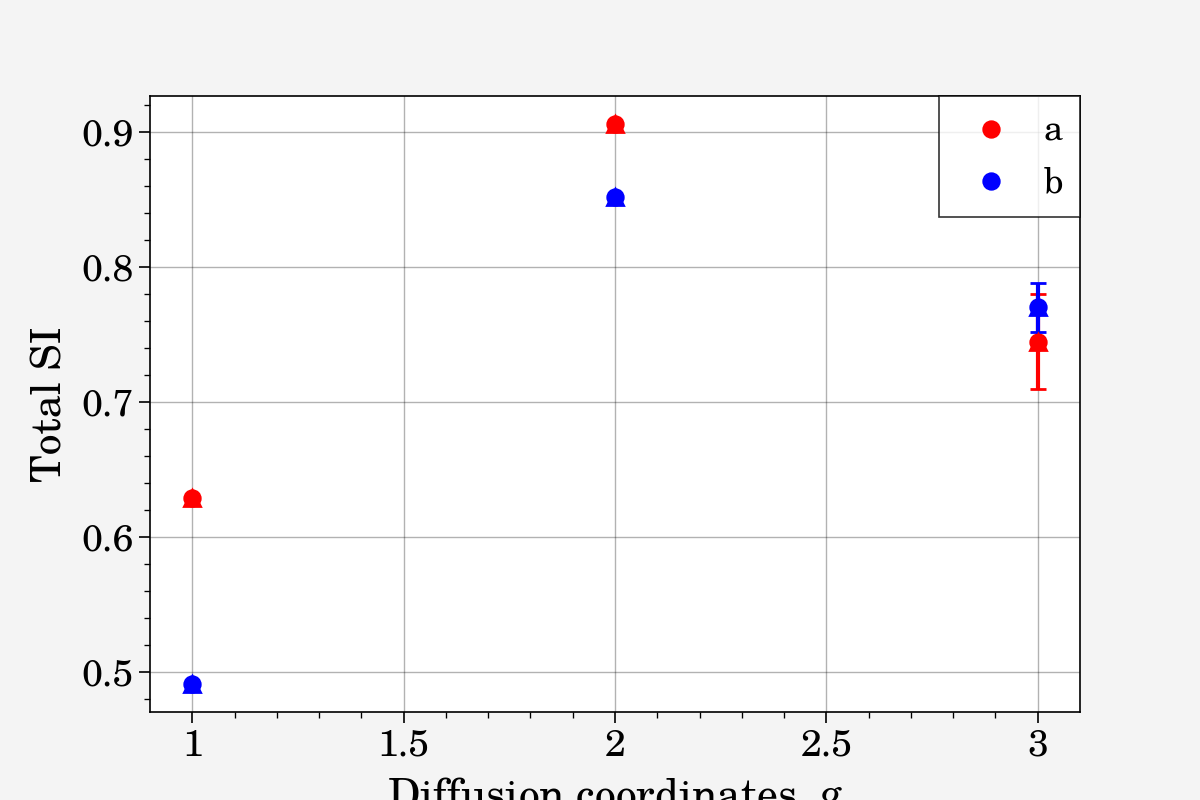

In [32]:
n_iter = 50
n_uncertain_param = 2
n_d_coord = 3
n_samples = 512

pce_total_si = np.zeros((n_iter, n_uncertain_param, n_d_coord))
pce_first_si = np.zeros((n_iter, n_uncertain_param, n_d_coord))

for i in range(n_iter):
    
    x = joint.rvs(n_samples)
    
    out = []

    for j in range(x.shape[0]):
        out_ = Lotka_Voltera(x[j, 0], x[j, 1], c, d, t)
        out_ = out_.T.flatten() # keep both species
        out.append(out_)

    data = np.array(out)
    data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))
    
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                       n_evecs=20,
                                                       n_parsim=3, 
                                                       p=10).get()
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=6, 
                          verbose=False).get()
    
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()
    
    for p in range(n_uncertain_param):
        pce_total_si[i, p, :] = pce_to_si[p]
        pce_first_si[i, p, :] = pce_fo_si[p]
    
plt.scatter(np.arange(1, g.shape[1]+1, 1), pce_total_si.mean(axis=0)[0], c='r', label='a')
plt.scatter(np.arange(1, g.shape[1]+1, 1), pce_total_si.mean(axis=0)[1], c='b', label='b')
plt.errorbar(np.arange(1, g.shape[1]+1, 1), 
             pce_total_si.mean(axis=0)[0], 
             pce_total_si.var(axis=0, ddof=1)[0], linestyle='None', c='r', marker='^')
plt.errorbar(np.arange(1, g.shape[1]+1, 1), 
             pce_total_si.mean(axis=0)[1], 
             pce_total_si.var(axis=0, ddof=1)[1], linestyle='None', c='b', marker='^')
plt.xlabel(r'Diffusion coordinates, $g$')
plt.ylabel('Total SI')
plt.legend()

plt.show()



In [34]:
param_names = [r'$\alpha$', r'$\beta$']
error_marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
colors=mcp.gen_color(cmap="Dark2",n=7)
# param_names = ['a', 'b', 'c', 'd']

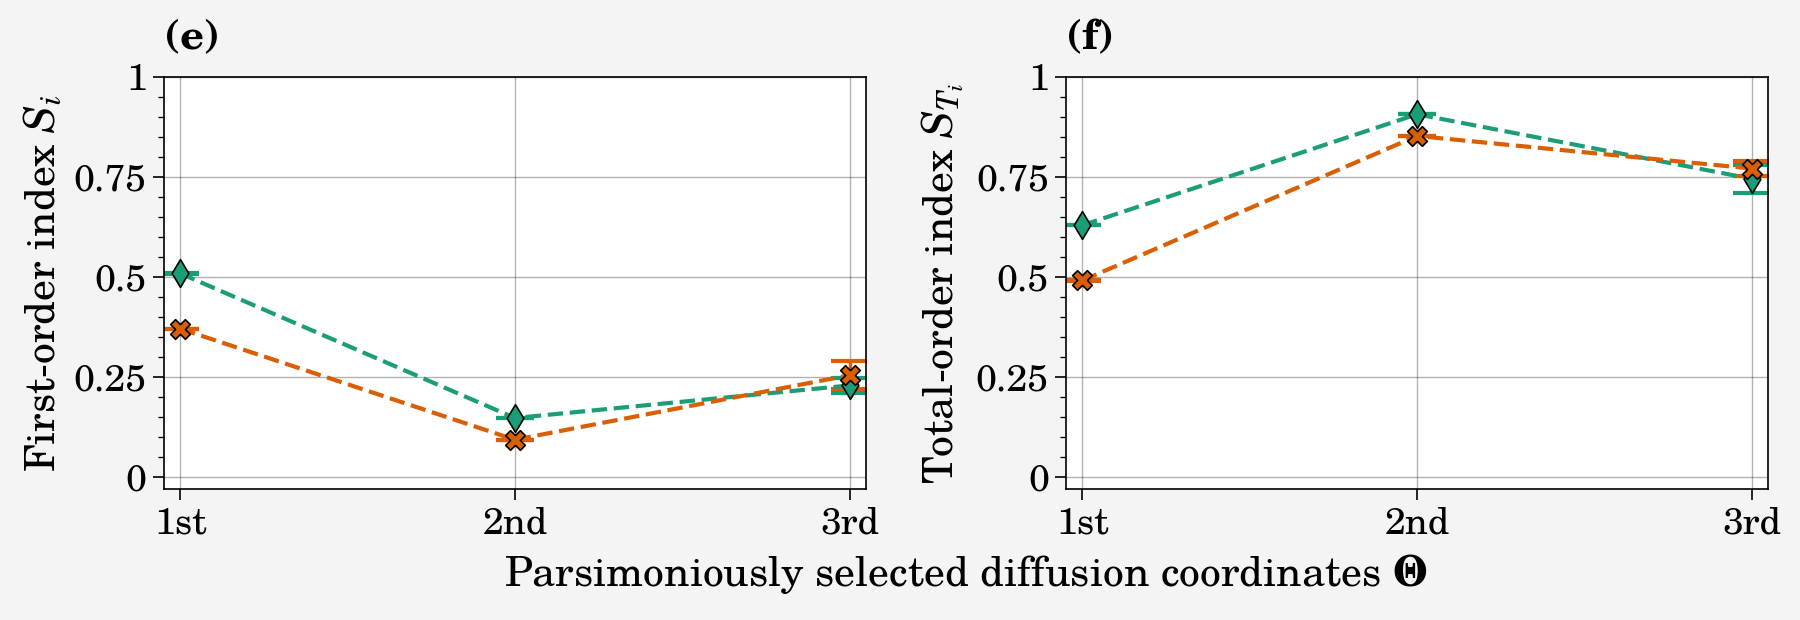

In [40]:
sobol_si_pce = [pce_first_si, pce_total_si]


fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(9, 3.1), sharex=True, sharey=False)

for j, si in enumerate(sobol_si_pce):
    for i, param in enumerate(param_names):
        axs[j].scatter(np.linspace(1, 3, 3, dtype='int'), si.mean(axis=0)[i], 
                       color=colors[i], label=param_names[i], 
                       edgecolor='k', marker=error_marker_styles[i], 
                       markersize=50, zorder=3)
        axs[j].errorbar(np.linspace(1, 3, 3, dtype='int'), si.mean(axis=0)[i], 
                        si.var(axis=0, ddof=1)[i],
                        color=colors[i], markeredgewidth=1.5, linestyle='--', 
                        capsize=7, alpha=1, elinewidth=1.2)

    for ax in axs:
        ax.format(xticklabels=['1st', '2nd',  '3rd'],
                  xticks = [1, 2, 3], xlim=(0.95, 3.05), ylim=(-0.03, 1),
                  xlabel=r'Parsimoniously selected diffusion coordinates $\bf{\Theta}$')
                  
        if ax == axs[1]:
            ax.format(ylabel=r'Total-order index $S_{T_i}$', title='(f)', 
                      titleloc='left', titlepad=10, titleweight='bold')
        else:
            ax.format(ylabel=r'First-order index $S_i$', title='(e)', 
                      titleloc='left', titlepad=10, titleweight='bold')
            
# fig.legend(param_names, ncols=4, frame=False, loc='t',
#            fontsize = 15, title_fontsize=15.5)

fig.tight_layout()
plt.savefig('plots/LV_2vars_PCE_GSA.pdf', bbox_inches='tight')
plt.show()


In [41]:
# defining problem
problem = {
  'num_vars': 2, 
  'names': ['a', 'b'],
  'bounds': [[0.9, 1.05], 
             [0.1, 0.18]]
}

# Generate samples
param_vals = saltelli.sample(problem, 1024, calc_second_order=False)

# Fixed parameters:
c = 1.5
d = 0.75
             
# Timesteps array
n = 512 
t = np.linspace(0, 25,  n)  

# Lists storing the S1 and ST for different timesteps
Si_u_S1 = []
Si_u_ST = []
Si_u_S1_conf = []
Si_u_ST_conf = []

Si_v_S1 = []
Si_v_ST = []
Si_v_S1_conf = []
Si_v_ST_conf = []

steps = np.linspace(20, 511, 15, dtype='int')

for step in steps:
    # Initializing matrix to store output
    Y = np.zeros([len(param_vals), 2])

    for i in range(param_vals.shape[0]):
        Y[i, :] = Lotka_Voltera(param_vals[i, 0], 
                                param_vals[i, 1], 
                                c, 
                                d,
                                t)[step] # step in the loop

    # Completing sobol analysis for each u and v separately
    Si_u = sobol.analyze(problem, Y[:,0], calc_second_order=False)
    Si_u_S1.append(Si_u['S1'])
    Si_u_ST.append(Si_u['ST'])
    Si_u_S1_conf.append(Si_u['S1_conf'])
    Si_u_ST_conf.append(Si_u['ST_conf'])
    
    Si_v = sobol.analyze(problem, Y[:,1], calc_second_order=False)
    Si_v_S1.append(Si_v['S1'])
    Si_v_ST.append(Si_v['ST'])
    Si_v_S1_conf.append(Si_v['S1_conf'])
    Si_v_ST_conf.append(Si_v['ST_conf'])

In [46]:
pce_total_si.mean(axis=0)

array([[0.62761367, 0.9053677 , 0.7309497 ],
       [0.49285098, 0.85129338, 0.78535242]])

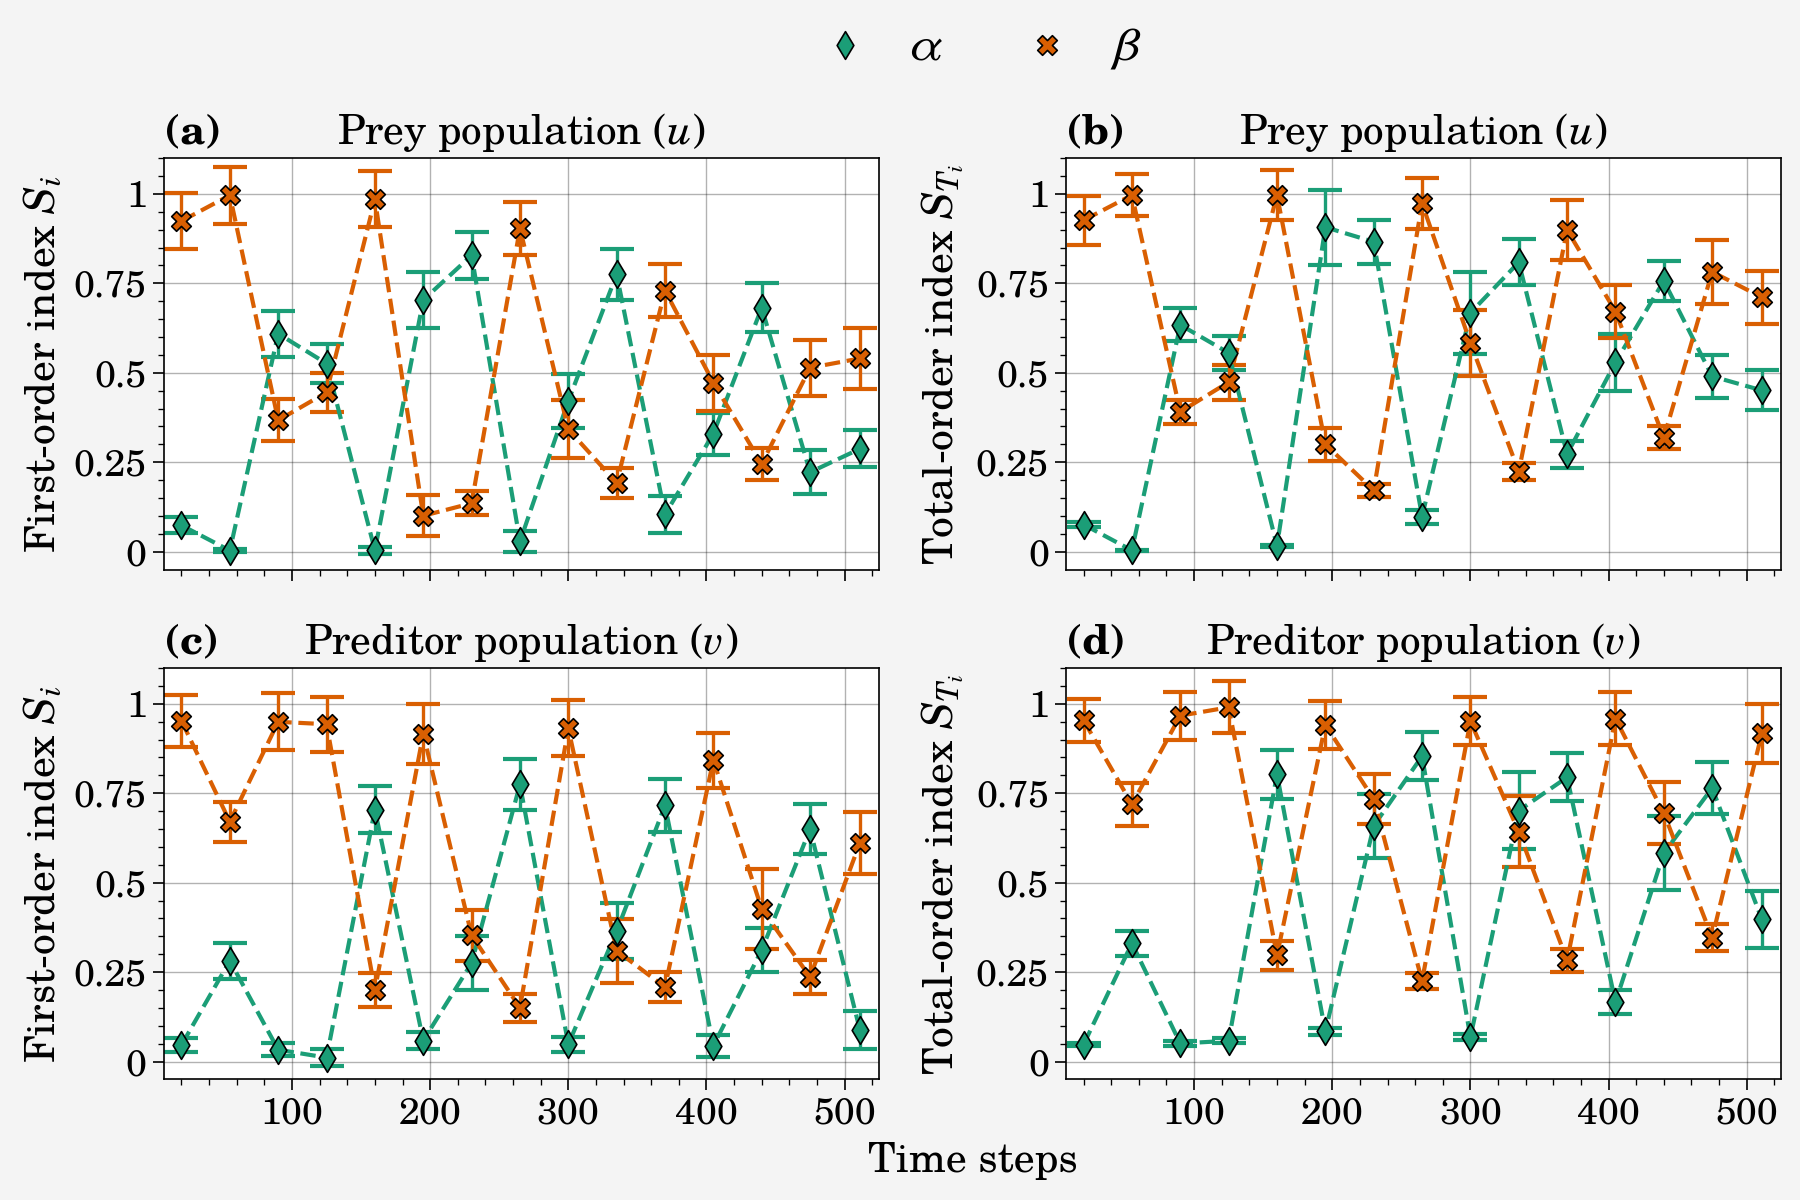

In [42]:
fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(9, 6), sharex=True, sharey=False)

sobol_indices = [np.asarray(Si_u_S1), np.asarray(Si_u_ST), 
                 np.asarray(Si_v_S1), np.asarray(Si_v_ST)] 
sobol_ind_conf = [np.asarray(Si_u_S1_conf), np.asarray(Si_u_ST_conf),
                  np.asarray(Si_v_S1_conf), np.asarray(Si_v_ST_conf)]

for j, si in enumerate(sobol_indices):
    for i, param in enumerate(param_names):
        axs[j].scatter(steps, si[:, i], 
                       color=colors[i], label=param_names[i], 
                       edgecolor='k', marker=error_marker_styles[i], 
                       markersize=50, zorder=3)
        axs[j].errorbar(steps, si[:, i], sobol_ind_conf[j][:, i],
                        color=colors[i], markeredgewidth=1.5, linestyle='--', 
                        capsize=6, alpha=1, elinewidth=1.2)

#     axs[0].plot(steps, np.asarray(Si_u_S1)[:, i], param_styles[i], 
#             cycle='Dark2', label=param, markersize=7,
#             markeredgecolor='k')
#     axs[1].plot(steps, np.asarray(Si_u_ST)[:, i], param_styles[i], 
#             cycle='Dark2', label=param, markersize=7,
#             markeredgecolor='k')
#     axs[2].plot(steps, np.asarray(Si_v_S1)[:, i], param_styles[i], 
#             cycle='Dark2', label=param, markersize=7,
#             markeredgecolor='k')
#     axs[3].plot(steps, np.asarray(Si_v_ST)[:, i], param_styles[i], 
#             cycle='Dark2', label=param, markersize=7,
#             markeredgecolor='k')
    
    for ax in axs:
        ax.format(xlim=(7, 525),
                  abc='a.', xlabel='Time steps')
                  
        if ax == axs[1] or ax == axs[3]:
            ax.format(ylabel=r'Total-order index $S_{T_i}$',
                      ylim=(-0.05, 1.1))
        else:
            ax.format(ylabel=r'First-order index $S_i$',
                     ylim=(-0.05, 1.1))
            
        if ax == axs[0] or ax == axs[1]:
            ax.format(title=r'Prey population $(u)$')
        else:
            ax.format(title=r'Preditor population $(v)$')
        
        
fig.legend(param_names, ncols=4, frame=False, loc='t',
           fontsize = 15, title_fontsize=15.5)

axs.format(abc='(a)')
#            leftlabels=(r'Prey population $(u)$', 
#                                  r'Preditor population $(v)$'))

fig.tight_layout()
plt.savefig('plots/LV_2vars_SALib.pdf', bbox_inches='tight')
plt.show()

# All four parameters

In [55]:
# Probability distributions of input parameters
pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
pdf3 = Uniform(loc=8, scale=10)  # c
pdf4 = Uniform(loc=8, scale=10)  # d

margs = [pdf1, pdf2, pdf3, pdf4]
joint = JointIndependent(marginals=margs)

In [56]:
# defining problem
problem = {
  'num_vars': 4, 
  'names': ['a', 'b', 'c', 'd'],
  'bounds': [[0.9, 1.05], 
             [0.1, 0.18],
             [8, 18], 
             [8, 18]]
}

# Generate samples using saltelli from SALib
x = saltelli.sample(problem, 1024, calc_second_order=False)

# Timesteps array
n = 512 
t = np.linspace(0, 25,  n) 

out = []

for j in range(x.shape[0]):
    out_ = Lotka_Voltera(x[j, 0], x[j, 1], x[j, 2], x[j, 3], t)
    out_ = out_.T.flatten() # keep both species
    out.append(out_)

data = np.array(out)
data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [57]:
x.shape

(6144, 4)

In [137]:
if not os.path.exists(f'GSA_results/LV/4_params_parsim_1024_PCE_10.npz'):
    start_time = time.time()

    # Perform GDMAps
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                             n_evecs=20,
                                                             n_parsim=3, 
                                                             p=10).get() 

    print("--- GDMaps - %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    # Perform PCE on the manifold
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=True).get()

    print('Error of PCE:', error)
    print("--- Surrogate - %s seconds ---" % (time.time() - start_time))
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()
    pce_gto_si = PceSensitivity(pce).calculate_generalized_total_order_indices()
    pce_gfo_si = PceSensitivity(pce).calculate_generalized_first_order_indices()

    print('Generalized total order:')
    print(pce_gto_si)
    print('Generalized first order:')
    print(pce_gfo_si)
    print('Experimental design shape (input):')
    print(pce.experimental_design_input.shape)
    print('Experimental design shape (output):')
    print(pce.experimental_design_output.shape)
    
    np.savez(f'GSA_results/LV/4_params_parsim_1024_PCE_10.npz',
             x1 = pce_to_si, 
             x2 = pce_fo_si, 
             x3 = pce_gto_si, 
             x4 = pce_gfo_si,
             x5 = evals,
             x6 = evecs,
             x7 = coord,
             x8 = g,
             x9 = residuals,
             x10 = index,
             x11 = error)
else:
    file_res = np.load(f'GSA_results/LV/4_params_parsim_1024_PCE_10.npz', 
                       allow_pickle=True)
    
    pce_to_si = file_res['x1']
    pce_fo_si = file_res['x2']
    pce_gto_si = file_res['x3']
    pce_gfo_si = file_res['x4']       
    evals = file_res['x5'] # evals_diff_runs
    evecs = file_res['x6'] # evecs_diff_runs
    coord = file_res['x7'] # coord_diff_runs
    g = file_res['x8']     # g_diff_runs
    residuals = file_res['x9'] # residuals_diff_runs
    index = file_res['x10']    # index_diff_runs
    error = file_res['x11']



In [138]:
if not os.path.exists('GSA_results/LV'):
    os.makedirs('GSA_results/LV')

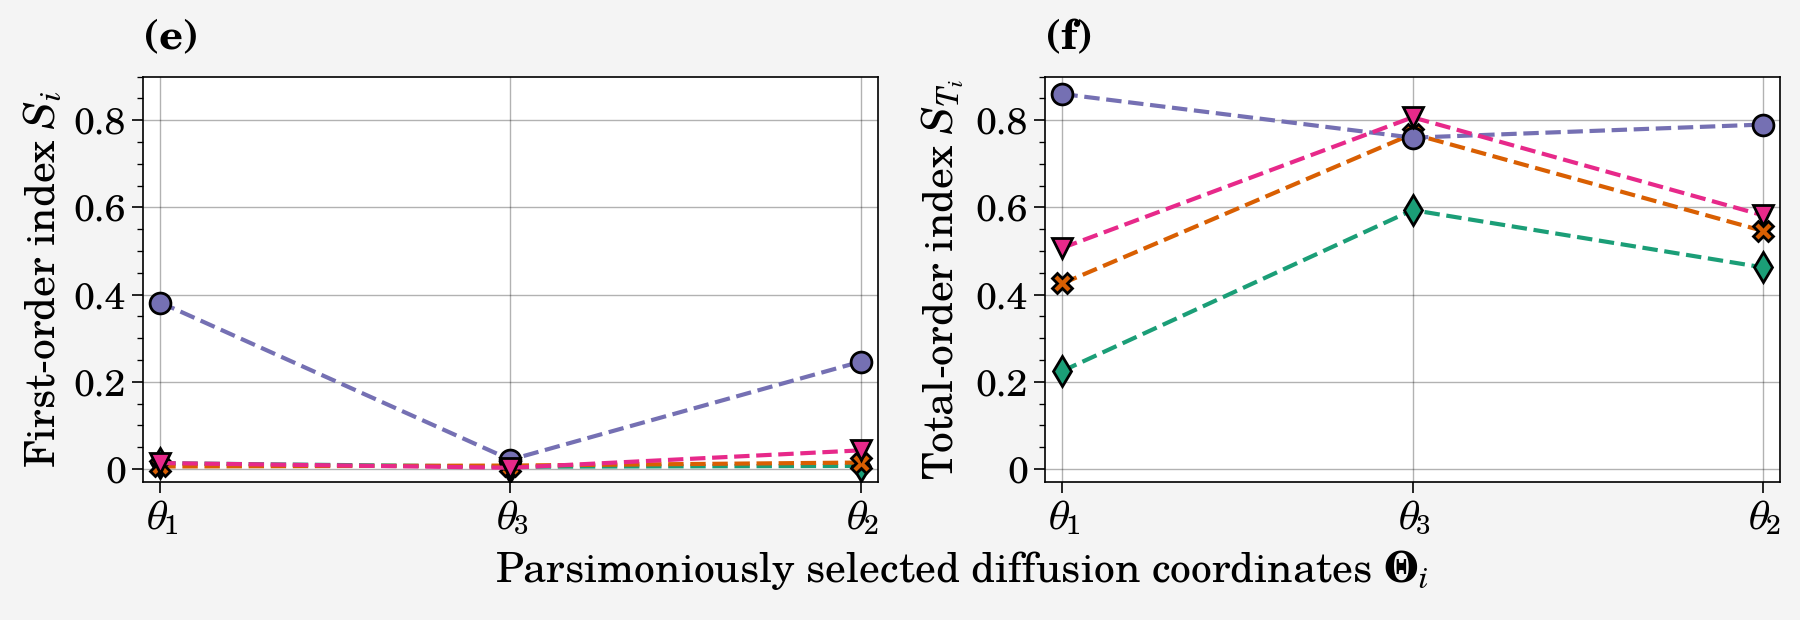

In [149]:
param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
param_styles = ['d--', 'X--', 'o--',  'v--', 'P--', 's--','*--']
colors=mcp.gen_color(cmap="Dark2",n=9)
# param_names = ['a', 'b', 'c', 'd']

fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(9, 3.1), sharex=True, sharey=False)


for i, param in enumerate(param_names):
    axs[0].plot(np.linspace(1, 3, 3, dtype='int'), pce_fo_si[i], param_styles[i],
                label=param_names[i], color=colors[i], markeredgecolor='k', markersize=7.5)
    axs[1].plot(np.linspace(1, 3, 3, dtype='int'), pce_to_si[i], param_styles[i],
                label=param_names[i], color=colors[i], markeredgecolor='k', markersize=7.5)
    
    for ax in axs:
        ax.format(xticklabels=[r'$\theta_{{{}}}$'.format(c) for i, c in enumerate(coord)],
                  xticks = [1, 2, 3], xlim=(0.95, 3.05), ylim=(-0.03, 0.9),
                  xlabel=r'Parsimoniously selected diffusion coordinates $\bf{\Theta}$$_i$')
                  
        if ax == axs[1]:
            ax.format(ylabel=r'Total-order index $S_{T_i}$', title='(f)', 
                      titleloc='left', titlepad=10, titleweight='bold')
        else:
            ax.format(ylabel=r'First-order index $S_i$', title='(e)', 
                      titleloc='left', titlepad=10, titleweight='bold')
            
# fig.legend(param_names, ncols=4, frame=False, loc='t',
#            fontsize = 15, title_fontsize=15.5)

fig.tight_layout()
plt.savefig('plots/LV_PCE_GSA.pdf', bbox_inches='tight')
plt.show()


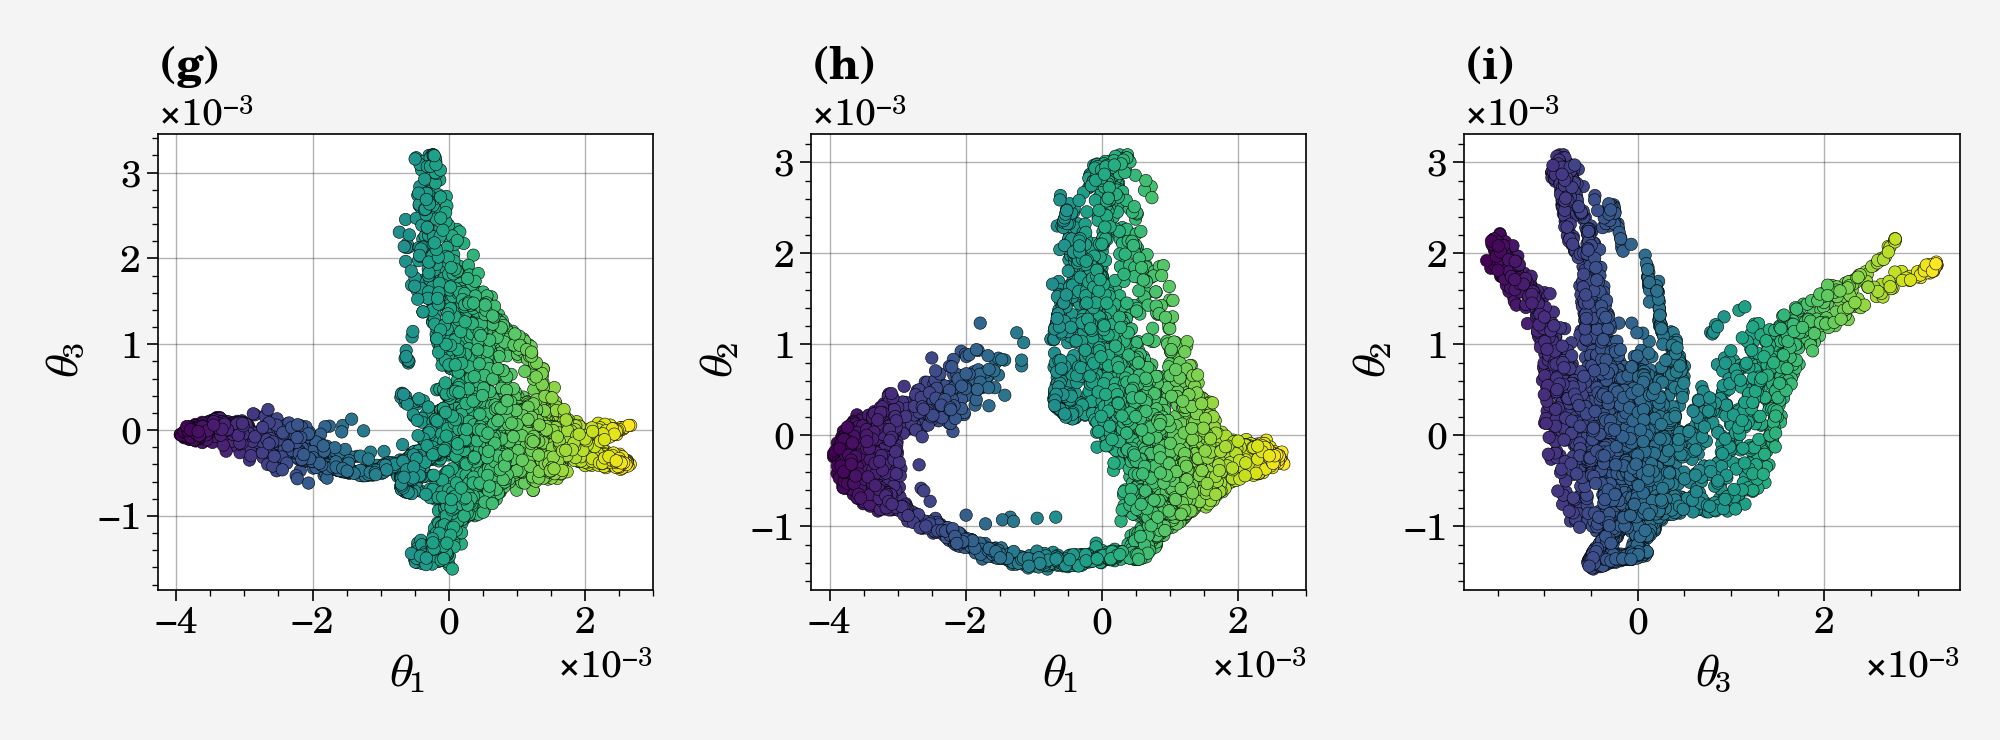

In [143]:
# Plotting diffusion coordinates

pplt.rc['grid.linewidth'] = 0.5
pplt.rc['grid.alpha'] = 0.3

numbering= ['(g)', '(h)', '(i)']

comb1 = list(it.combinations(list(coord), 2))
comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

# Plot first three plots
if coord.shape[0] > 2:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.7), constrained_layout=True)
    for i in range(len(comb1)):
        ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                      cmap='viridis', s=20, 
                      edgecolors='k', 
                      linewidth=0.2)
        ax[i].set_xlabel(r'$\theta_{}$'.format(comb1[i][0]))
        ax[i].set_ylabel(r'$\theta_{}$'.format(comb1[i][1]))
        ax[i].grid('True')
        ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        ax[i].set_title(r'$\bf{{{}}}$'.format(numbering[i]), loc='left', pad=20, size=16)
    fig.tight_layout()
    plt.savefig('plots/LV_PCE_dcoords.png', dpi=300, bbox_inches='tight')
    plt.show()
    

In [45]:
scipy.special.binom(5+25, 5)*2/4779


59.63841807909605

# Sampling: Low-discrepancy sequences (e.g. Sobol sequence)

In [151]:
def sobol_sequence_sampler(nsamples, n_uncertain_param, l_bounds, u_bounds, seed = None):
    if seed:
        sampler = stats.qmc.Sobol(d = n_uncertain_param, seed = seed)
    else:
        sampler = stats.qmc.Sobol(d = n_uncertain_param)
    
    samples_count = np.int64(np.ceil(np.log2(nsamples)))
    
    samples = sampler.random_base2(samples_count)
    samples = stats.qmc.scale(samples, l_bounds, u_bounds)
#     np.random.shuffle(samples) # shuffle or not?
#     samples = samples[:nsamples]
    
    return samples

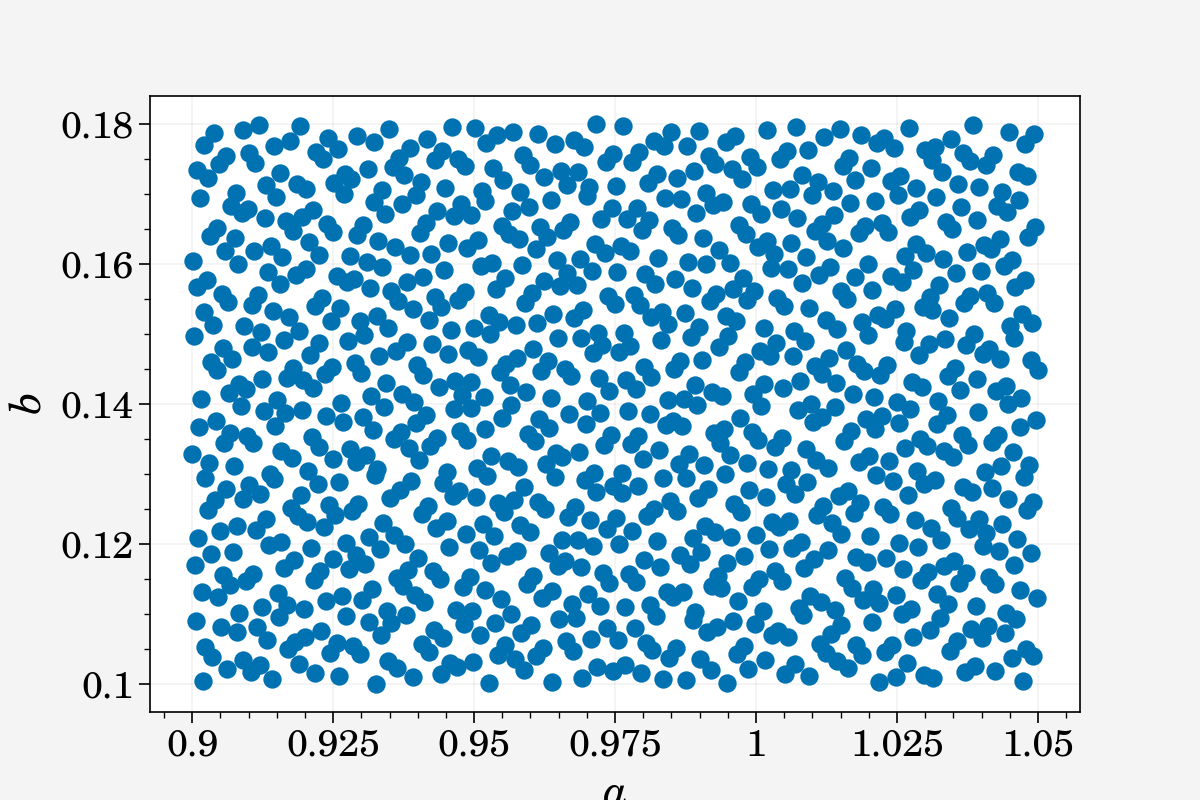

In [153]:
# Low-discrepancy sampler

n_samples = 1024 # as power of 2 or just 600?
n_uncertain_param = 2

l_bounds = [0.9,   0.1] # lower bounds of a and b
u_bounds = [1.05, 0.18] # upper bounds of a and b

x_sobol = sobol_sequence_sampler(n_samples, n_uncertain_param, l_bounds, u_bounds)

plt.scatter(x_sobol[:, 0], x_sobol[:, 1])
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.show()

generating random samples using sobol rule
order: 1024, dim: 2 -> shape: (2, 1024)


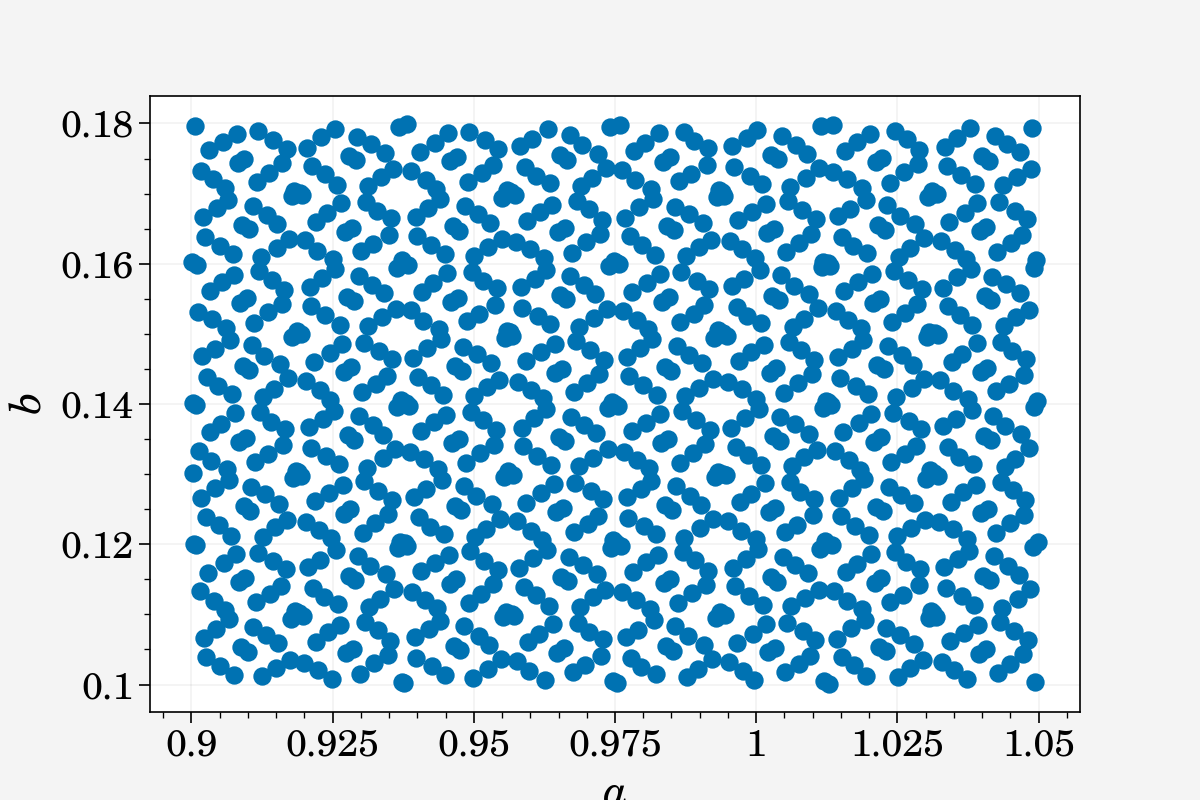

In [157]:
import chaospy

dist1 = chaospy.Uniform(0.9, 1.05)
dist2 = chaospy.Uniform(0.1, 0.18)
dist3 = chaospy.Uniform(8, 18)
dist4 = chaospy.Uniform(8, 18)
x = chaospy.J(dist1, dist2, dist3, dist4).sample(1024, rule="sobol").T

plt.scatter(x[:, 0], x[:, 1])
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.show()

Iteration:  1
Grassmann projection rank is:  10
Generalized total order:
[0.67459545 0.55703929]
Generalized first order:
[0.44296071 0.32540455]
Experimental design shape (input):
(2730, 2)
Experimental design shape (output):
(2730, 3)
Iteration:  2
Grassmann projection rank is:  10
Generalized total order:
[0.67568646 0.55594417]
Generalized first order:
[0.44405583 0.32431354]
Experimental design shape (input):
(2730, 2)
Experimental design shape (output):
(2730, 3)


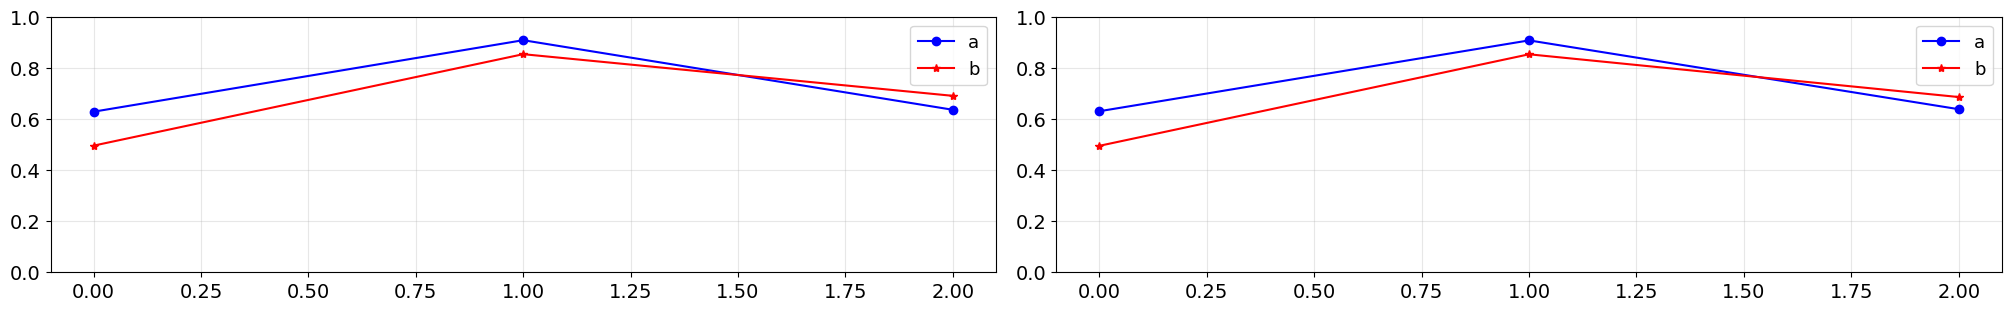

In [106]:
# check using sobol sequence

n_iter = 2
n_samples = 4096
n_uncertain_param = 2

l_bounds = [0.9,   0.1] # lower bounds of a and b
u_bounds = [1.05, 0.18] # upper bounds of a and b

pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
c = 1.5
d = 0.75

margs = [pdf1, pdf2]
joint = JointIndependent(marginals=margs)

fig, axs = plt.subplots(1, n_iter, figsize=(20, 3), constrained_layout = True)

for i in range(n_iter):
    print('Iteration: ', i+1)
    
    x = sobol_sequence_sampler(n_samples, n_uncertain_param, l_bounds, u_bounds)
    out = []

    for j in range(x.shape[0]):
        out_ = Lotka_Voltera(x[j, 0], x[j, 1], c, d, t)
        out_ = out_.T.flatten() # keep both species
        out.append(out_)

    data = np.array(out)
    data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2))) # why reshaped in such a way?
    
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                       n_evecs=20,
                                                       n_parsim=3, 
                                                       p=10).get()
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=False).get()
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_gto_si = PceSensitivity(pce).calculate_generalized_total_order_indices()
    pce_gfo_si = PceSensitivity(pce).calculate_generalized_first_order_indices()
    axs[i].plot(pce_to_si[0],'b-o', label='a')
    axs[i].plot(pce_to_si[1], 'r-*', label='b')
#     axs[i].plot(pce_to_si[2], 'g-X', label='c')
#     axs[i].plot(pce_to_si[3], 'k-*', label='d')
    axs[i].set_ylim(0, 1)
    axs[i].legend()
    print('Generalized total order:')
    print(pce_gto_si)
    print('Generalized first order:')
    print(pce_gfo_si)
    print('Experimental design shape (input):')
    print(pce.experimental_design_input.shape)
    print('Experimental design shape (output):')
    print(pce.experimental_design_output.shape)
plt.show()

Iteration:  1
Grassmann projection rank is:  10
Generalized total order:
[0.67455833 0.55657446]
Generalized first order:
[0.44342554 0.32544167]
Experimental design shape (input):
(1365, 2)
Experimental design shape (output):
(1365, 3)
Iteration:  2
Grassmann projection rank is:  10
Generalized total order:
[0.67307889 0.55765859]
Generalized first order:
[0.44234141 0.32692111]
Experimental design shape (input):
(1365, 2)
Experimental design shape (output):
(1365, 3)


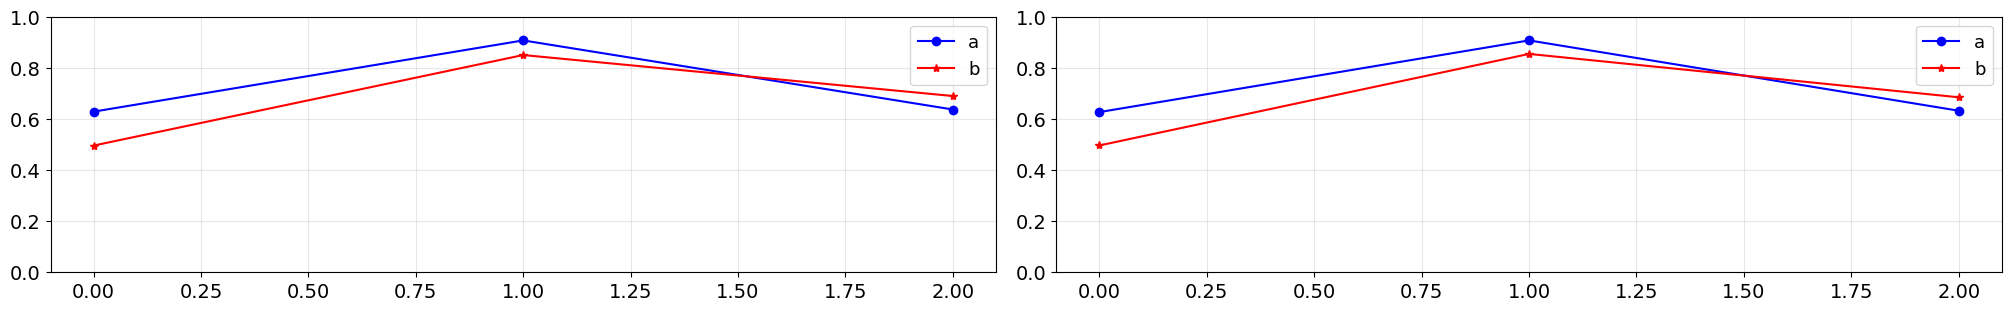

In [107]:
# Sobol sequence with 2048 - resampled twice

n_iter = 2
n_samples = 2048
n_uncertain_param = 2

l_bounds = [0.9,   0.1] # lower bounds of a and b
u_bounds = [1.05, 0.18] # upper bounds of a and b

pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
c = 1.5
d = 0.75

margs = [pdf1, pdf2]
joint = JointIndependent(marginals=margs)

fig, axs = plt.subplots(1, n_iter, figsize=(20, 3), constrained_layout = True)

for i in range(n_iter):
    print('Iteration: ', i+1)
    
    x = sobol_sequence_sampler(n_samples, n_uncertain_param, l_bounds, u_bounds)
    out = []

    for j in range(x.shape[0]):
        out_ = Lotka_Voltera(x[j, 0], x[j, 1], c, d, t)
        out_ = out_.T.flatten() # keep both species
        out.append(out_)

    data = np.array(out)
    data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2))) # why reshaped in such a way?
    
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                       n_evecs=20,
                                                       n_parsim=3, 
                                                       p=10).get()
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=False).get()
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_gto_si = PceSensitivity(pce).calculate_generalized_total_order_indices()
    pce_gfo_si = PceSensitivity(pce).calculate_generalized_first_order_indices()
    axs[i].plot(pce_to_si[0],'b-o', label='a')
    axs[i].plot(pce_to_si[1], 'r-*', label='b')
#     axs[i].plot(pce_to_si[2], 'g-X', label='c')
#     axs[i].plot(pce_to_si[3], 'k-*', label='d')
    axs[i].set_ylim(0, 1)
    axs[i].legend()
    print('Generalized total order:')
    print(pce_gto_si)
    print('Generalized first order:')
    print(pce_gfo_si)
    print('Experimental design shape (input):')
    print(pce.experimental_design_input.shape)
    print('Experimental design shape (output):')
    print(pce.experimental_design_output.shape)
plt.show()

Iteration:  1
Grassmann projection rank is:  10
Generalized total order:
[0.67473966 0.55576047]
Generalized first order:
[0.44423953 0.32526034]
Experimental design shape (input):
(1365, 2)
Experimental design shape (output):
(1365, 3)
Iteration:  2
Grassmann projection rank is:  10
Generalized total order:
[0.67473966 0.55576047]
Generalized first order:
[0.44423953 0.32526034]
Experimental design shape (input):
(1365, 2)
Experimental design shape (output):
(1365, 3)


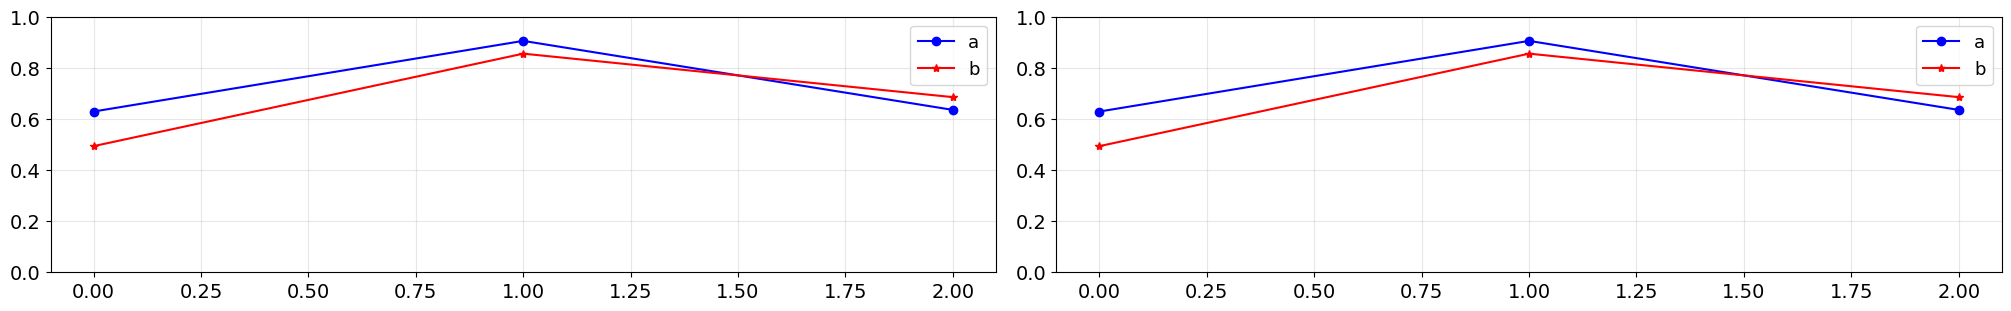

In [108]:
# Sobol sequence with 2048 - without resampling - no shange!

n_iter = 2
n_samples = 2048
n_uncertain_param = 2

l_bounds = [0.9,   0.1] # lower bounds of a and b
u_bounds = [1.05, 0.18] # upper bounds of a and b

pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
c = 1.5
d = 0.75

margs = [pdf1, pdf2]
joint = JointIndependent(marginals=margs)

x = sobol_sequence_sampler(n_samples, n_uncertain_param, l_bounds, u_bounds)
out = []

for j in range(x.shape[0]):
    out_ = Lotka_Voltera(x[j, 0], x[j, 1], c, d, t)
    out_ = out_.T.flatten() # keep both species
    out.append(out_)

data = np.array(out)
data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))

fig, axs = plt.subplots(1, n_iter, figsize=(20, 3), constrained_layout = True)

for i in range(n_iter):
    print('Iteration: ', i+1)
    
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                       n_evecs=20,
                                                       n_parsim=3, 
                                                       p=10).get()
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=False).get()
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_gto_si = PceSensitivity(pce).calculate_generalized_total_order_indices()
    pce_gfo_si = PceSensitivity(pce).calculate_generalized_first_order_indices()
    axs[i].plot(pce_to_si[0],'b-o', label='a')
    axs[i].plot(pce_to_si[1], 'r-*', label='b')
#     axs[i].plot(pce_to_si[2], 'g-X', label='c')
#     axs[i].plot(pce_to_si[3], 'k-*', label='d')
    axs[i].set_ylim(0, 1)
    axs[i].legend()
    print('Generalized total order:')
    print(pce_gto_si)
    print('Generalized first order:')
    print(pce_gfo_si)
    print('Experimental design shape (input):')
    print(pce.experimental_design_input.shape)
    print('Experimental design shape (output):')
    print(pce.experimental_design_output.shape)
plt.show()

Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10


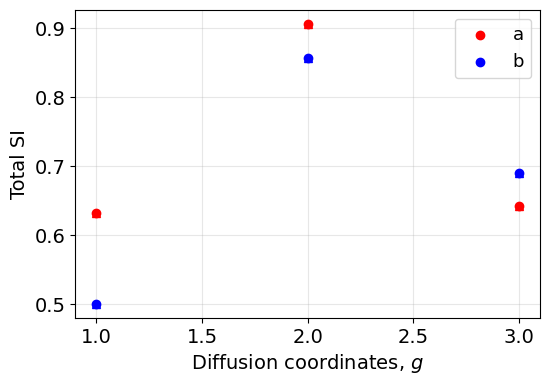

In [9]:
# Low-discrepancy sampling design

l_bounds = [0.9,   0.1] # lower bounds of a and b
u_bounds = [1.05, 0.18] # upper bounds of a and b

n_iter = 10
n_uncertain_param = 2
n_d_coord = 3
n_samples = 512 # use power of 2

pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
c = 1.5
d = 0.75

margs = [pdf1, pdf2]
joint = JointIndependent(marginals=margs)

pce_total_si = np.zeros((n_iter, n_uncertain_param, n_d_coord))

for i in range(n_iter):
        
    x = sobol_sequence_sampler(n_samples, n_uncertain_param, l_bounds, u_bounds)
    
    out = []

    for j in range(x.shape[0]):
        out_ = Lotka_Voltera(x[j, 0], x[j, 1], c, d, t)
        out_ = out_.T.flatten() # keep both species
        out.append(out_)

    data = np.array(out)
    data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))
    
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                       n_evecs=20,
                                                       n_parsim=3, 
                                                       p=10).get()
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=False).get()
    
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    
    for p in range(n_uncertain_param):
        pce_total_si[i, p, :] = pce_to_si[p]   

plt.scatter(np.arange(1, g.shape[1]+1, 1), pce_total_si.mean(axis=0)[0], c='r', label='a')
plt.scatter(np.arange(1, g.shape[1]+1, 1), pce_total_si.mean(axis=0)[1], c='b', label='b')
plt.errorbar(np.arange(1, g.shape[1]+1, 1), 
             pce_total_si.mean(axis=0)[0], 
             pce_total_si.var(axis=0, ddof=1)[0], linestyle='None', c='r', marker='^')
plt.errorbar(np.arange(1, g.shape[1]+1, 1), 
             pce_total_si.mean(axis=0)[1], 
             pce_total_si.var(axis=0, ddof=1)[1], linestyle='None', c='b', marker='^')
plt.xlabel(r'Diffusion coordinates, $g$')
plt.ylabel('Total SI')
plt.legend()

plt.show()

Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10
Grassmann projection rank is:  10


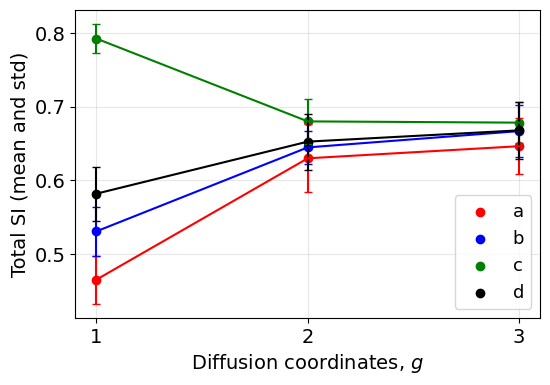

In [11]:
# Probability distributions of input parameters
pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
pdf3 = Uniform(loc=8, scale=10)  # c
pdf4 = Uniform(loc=8, scale=10)  # d

margs = [pdf1, pdf2, pdf3, pdf4]
joint = JointIndependent(marginals=margs)

l_bounds = [0.9,   0.1,  8,  8] # lower bounds of a, b, c, d
u_bounds = [1.05, 0.18, 18, 18] # upper bounds of a, b, c, d

n_iter = 20
n_uncertain_param = 4
n_d_coord = 3
n_samples = 512

pce_total_si = np.zeros((n_iter, n_uncertain_param, n_d_coord))

for i in range(n_iter):
    
    x = sobol_sequence_sampler(n_samples, n_uncertain_param, l_bounds, u_bounds)
    
    out = []

    for j in range(x.shape[0]):
        out_ = Lotka_Voltera(x[j, 0], x[j, 1], x[j, 2], x[j, 3], t)
        out_ = out_.T.flatten() # keep both species
        out.append(out_)

    data = np.array(out)
    data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2)))
    
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                       n_evecs=20,
                                                       n_parsim=3, 
                                                       p=10).get()
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=False).get()
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    
    pce_total_si[i, 0, :] = pce_to_si[0]
    pce_total_si[i, 1, :] = pce_to_si[1]
    pce_total_si[i, 2, :] = pce_to_si[2]
    pce_total_si[i, 3, :] = pce_to_si[3]
    

param_names = ['a', 'b', 'c', 'd']
colors = ['r', 'b', 'g', 'k']
coord_aray = np.arange(1, n_d_coord+1, 1)

for p in range(n_uncertain_param):

    plt.scatter(coord_aray, pce_total_si.mean(axis=0)[p], c=colors[p], label=param_names[p])

    plt.errorbar(coord_aray, 
                 pce_total_si.mean(axis=0)[p], 
                 pce_total_si.std(axis=0, ddof=1)[p], c=colors[p], capsize = 3)

plt.xticks(coord_aray, ['1', '2', '3'])
plt.xlabel(r'Diffusion coordinates, $g$')
plt.ylabel('Total SI (mean and std)')
plt.legend()

plt.show()

Iteration:  1
Grassmann projection rank is:  10
Generalized total order:
[0.43035982 0.5614984  0.84242358 0.59424841]
Generalized first order:
[0.01021171 0.00498041 0.2456886  0.01143396]
Experimental design shape (input):
(2730, 4)
Experimental design shape (output):
(2730, 3)
Iteration:  2
Grassmann projection rank is:  10
Generalized total order:
[0.45904654 0.55168709 0.82786067 0.61026743]
Generalized first order:
[0.01095465 0.00747078 0.22966368 0.01390946]
Experimental design shape (input):
(2730, 4)
Experimental design shape (output):
(2730, 3)


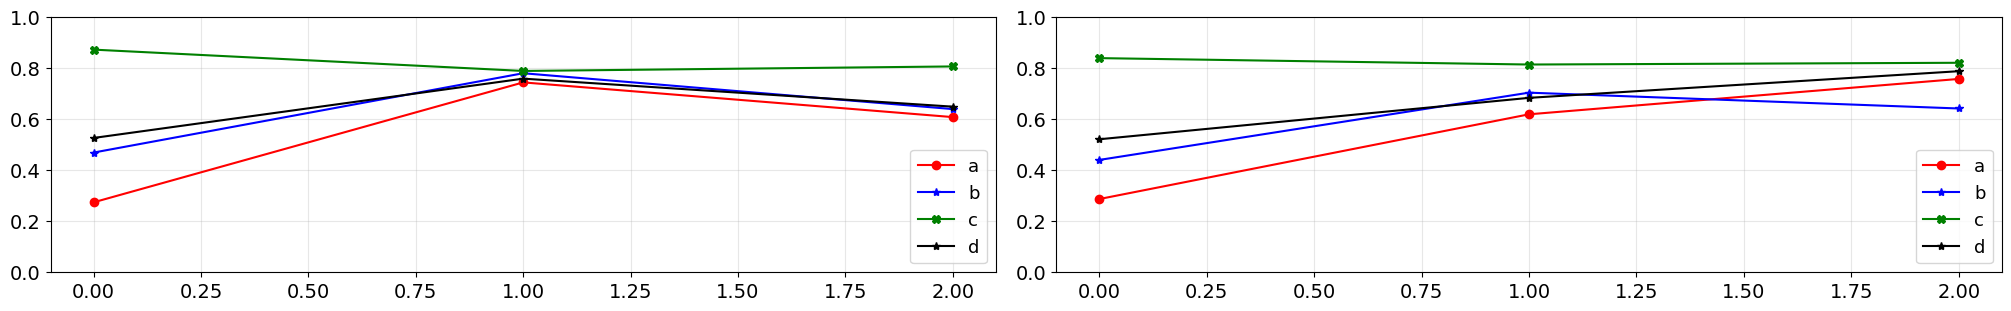

In [10]:
# Sobol sequence with 4096 - 4 params - resampled twice

n = 512 #2178
n2 = 2*n
t = np.linspace(0, 25,  n)  # time


# Probability distributions of input parameters
pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
pdf3 = Uniform(loc=8, scale=10)  # c
pdf4 = Uniform(loc=8, scale=10)  # d

margs = [pdf1, pdf2, pdf3, pdf4]
joint = JointIndependent(marginals=margs)

l_bounds = [0.9,   0.1,  8,  8] # lower bounds of a, b, c, d
u_bounds = [1.05, 0.18, 18, 18] # upper bounds of a, b, c, d

n_iter = 2
n_samples = 4096
n_uncertain_param = 4


fig, axs = plt.subplots(1, n_iter, figsize=(20, 3), constrained_layout = True)

for i in range(n_iter):
    print('Iteration: ', i+1)
    
    x = sobol_sequence_sampler(n_samples, n_uncertain_param, l_bounds, u_bounds)
    out = []

    for j in range(x.shape[0]):
        out_ = Lotka_Voltera(x[j, 0], x[j, 1], x[j, 2], x[j, 3], t)
        out_ = out_.T.flatten() # keep both species
        out.append(out_)

    data = np.array(out)
    data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2))) # why reshaped in such a way?
    
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                       n_evecs=20,
                                                       n_parsim=3, 
                                                       p=10).get()
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=False).get()
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_gto_si = PceSensitivity(pce).calculate_generalized_total_order_indices()
    pce_gfo_si = PceSensitivity(pce).calculate_generalized_first_order_indices()
    axs[i].plot(pce_to_si[0],'r-o', label='a')
    axs[i].plot(pce_to_si[1], 'b-*', label='b')
    axs[i].plot(pce_to_si[2], 'g-X', label='c')
    axs[i].plot(pce_to_si[3], 'k-*', label='d')
    axs[i].set_ylim(0, 1)
    axs[i].legend()
    print('Generalized total order:')
    print(pce_gto_si)
    print('Generalized first order:')
    print(pce_gfo_si)
    print('Experimental design shape (input):')
    print(pce.experimental_design_input.shape)
    print('Experimental design shape (output):')
    print(pce.experimental_design_output.shape)
plt.show()

Iteration:  1
Grassmann projection rank is:  10
Generalized total order:
[0.30988883 0.4848612  0.83576127 0.55292027]
Generalized first order:
[0.0111637  0.00774313 0.31761791 0.01821131]
Experimental design shape (input):
(4096, 4)
Experimental design shape (output):
(4096, 3)
Iteration:  2
Grassmann projection rank is:  10
Generalized total order:
[0.30988883 0.4848612  0.83576127 0.55292027]
Generalized first order:
[0.0111637  0.00774313 0.31761791 0.01821131]
Experimental design shape (input):
(4096, 4)
Experimental design shape (output):
(4096, 3)


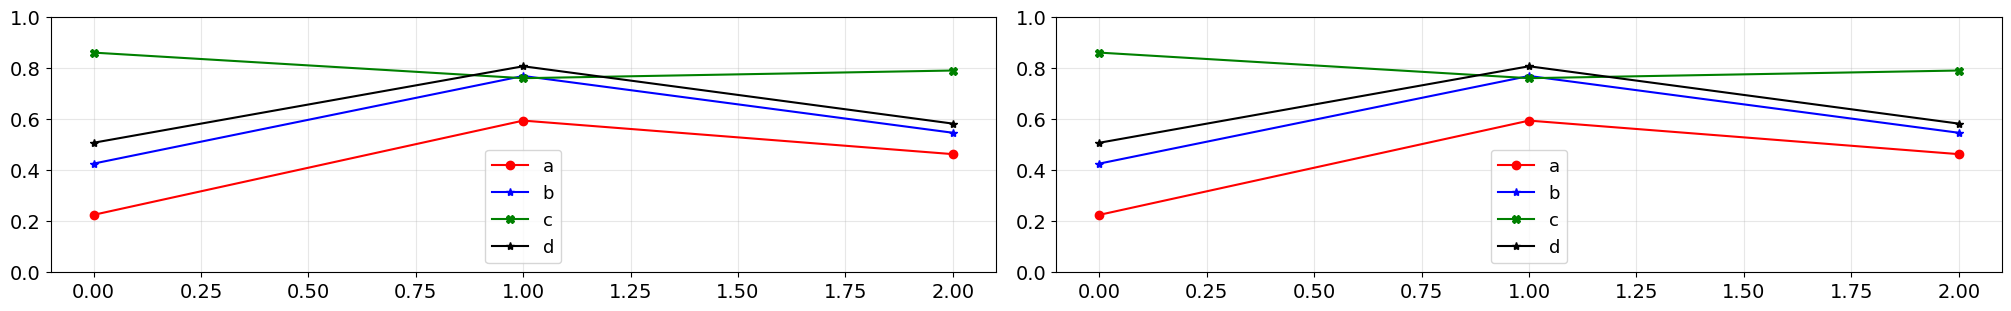

In [12]:
# Sobol sequence with 4096 - 4 params - resampled twice

n = 512 #2178
n2 = 2*n
t = np.linspace(0, 25,  n)  # time


# Probability distributions of input parameters
pdf1 = Uniform(loc=0.9, scale=0.15)  # a
pdf2 = Uniform(loc=0.1, scale=0.08)  # b
pdf3 = Uniform(loc=8, scale=10)  # c
pdf4 = Uniform(loc=8, scale=10)  # d

margs = [pdf1, pdf2, pdf3, pdf4]
joint = JointIndependent(marginals=margs)

uncertain_params = {
    'a': [float, [0.9, 1.05]],
    'b': [float, [0.1, 0.18]],
    'c': [float, [8, 18]],
    'd': [float, [8, 18]]
}

# defining problem
problem = {
  'num_vars': len(uncertain_params),
  'names': [key for key in sorted(uncertain_params.keys())],
  'bounds': [uncertain_params[key][1] for key in sorted(uncertain_params.keys())]
}

n_distinct_samples = 1024 #1024

n_iter = 2


fig, axs = plt.subplots(1, n_iter, figsize=(20, 3), constrained_layout = True)

for i in range(n_iter):
    print('Iteration: ', i+1)
    
    x = saltelli.sample(problem, n_distinct_samples, calc_second_order=False)
    out = []

    for j in range(x.shape[0]):
        out_ = Lotka_Voltera(x[j, 0], x[j, 1], x[j, 2], x[j, 3], t)
        out_ = out_.T.flatten() # keep both species
        out.append(out_)

    data = np.array(out)
    data = data.reshape(-1, int(np.sqrt(n2)), int(np.sqrt(n2))) # why reshaped in such a way?
    
    g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                       n_evecs=20,
                                                       n_parsim=3, 
                                                       p=10).get()
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=10, 
                          verbose=False).get()
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_gto_si = PceSensitivity(pce).calculate_generalized_total_order_indices()
    pce_gfo_si = PceSensitivity(pce).calculate_generalized_first_order_indices()
    axs[i].plot(pce_to_si[0],'r-o', label='a')
    axs[i].plot(pce_to_si[1], 'b-*', label='b')
    axs[i].plot(pce_to_si[2], 'g-X', label='c')
    axs[i].plot(pce_to_si[3], 'k-*', label='d')
    axs[i].set_ylim(0, 1)
    axs[i].legend()
    print('Generalized total order:')
    print(pce_gto_si)
    print('Generalized first order:')
    print(pce_gfo_si)
    print('Experimental design shape (input):')
    print(pce.experimental_design_input.shape)
    print('Experimental design shape (output):')
    print(pce.experimental_design_output.shape)
plt.show()

# Compare to MC Sobol Indices using SALib

In [93]:
# defining problem
problem = {
  'num_vars': 4, 
  'names': ['a', 'b', 'c', 'd'],
  'bounds': [[0.9, 1.05], 
             [0.1, 0.18],
             [8, 18], 
             [8, 18]]
}

# Generate samples
param_vals = saltelli.sample(problem, 1024, calc_second_order=False)

# Timesteps array
n = 512 
t = np.linspace(0, 25,  n)  
    
# Lists storing the S1 and ST for different timesteps
Si_u_S1 = []
Si_u_ST = []
Si_u_S1_conf = []
Si_u_ST_conf = []

Si_v_S1 = []
Si_v_ST = []
Si_v_S1_conf = []
Si_v_ST_conf = []

steps = np.linspace(20, 511, 15, dtype='int')

for step in steps:
    # Initializing matrix to store output
    Y = np.zeros([len(param_vals), 2])

    for i in range(param_vals.shape[0]):
        Y[i, :] = Lotka_Voltera(param_vals[i, 0], 
                                param_vals[i, 1], 
                                param_vals[i, 2], 
                                param_vals[i, 3], 
                                t)[step] # step in the loop

    # Completing sobol analysis for each u and v separately
    Si_u = sobol.analyze(problem, Y[:,0], calc_second_order=False)
    Si_u_S1.append(Si_u['S1'])
    Si_u_ST.append(Si_u['ST'])
    Si_u_S1_conf.append(Si_u['S1_conf'])
    Si_u_ST_conf.append(Si_u['ST_conf'])
    
    Si_v = sobol.analyze(problem, Y[:,1], calc_second_order=False)
    Si_v_S1.append(Si_v['S1'])
    Si_v_ST.append(Si_v['ST'])
    Si_v_S1_conf.append(Si_v['S1_conf'])
    Si_v_ST_conf.append(Si_v['ST_conf'])

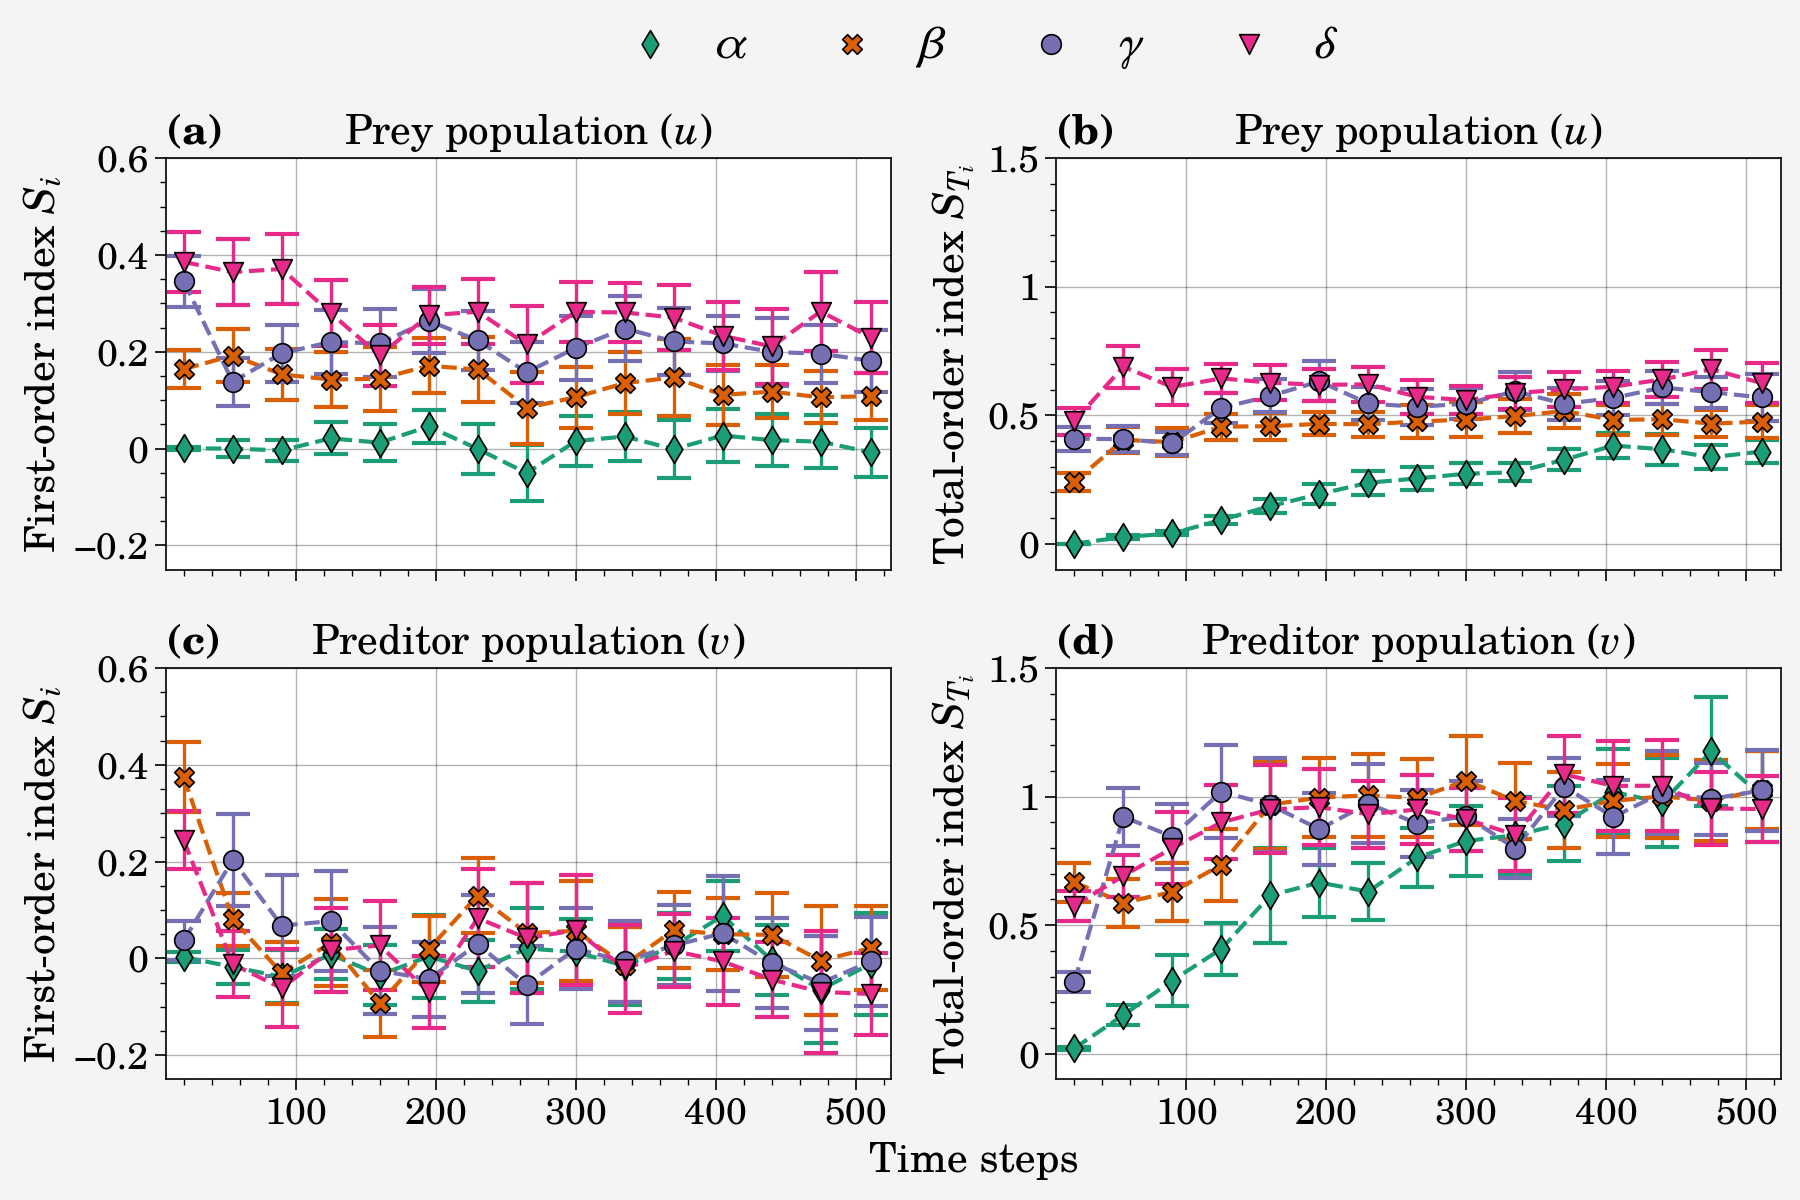

In [147]:
fig, axs = pplt.subplots(ncols=2, nrows=2, figsize=(9, 6), sharex=True, sharey=False)

param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
error_marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
colors=mcp.gen_color(cmap="Dark2",n=9)
# param_names = ['a', 'b', 'c', 'd']

sobol_indices = [np.asarray(Si_u_S1), np.asarray(Si_u_ST), 
                 np.asarray(Si_v_S1), np.asarray(Si_v_ST)] 
sobol_ind_conf = [np.asarray(Si_u_S1_conf), np.asarray(Si_u_ST_conf),
                  np.asarray(Si_v_S1_conf), np.asarray(Si_v_ST_conf)]

for j, si in enumerate(sobol_indices):
    for i, param in enumerate(param_names):
        axs[j].scatter(steps, si[:, i], 
                       color=colors[i], label=param_names[i], 
                       edgecolor='k', marker=error_marker_styles[i], 
                       markersize=50, zorder=3)
        axs[j].errorbar(steps, si[:, i], sobol_ind_conf[j][:, i],
                        color=colors[i], markeredgewidth=1.5, linestyle='--', 
                        capsize=6, alpha=1, elinewidth=1.2)
    
    for ax in axs:
        ax.format(xlim=(7, 525),
                  abc='(a)', xlabel='Time steps')
                  
        if ax == axs[1] or ax == axs[3]:
            ax.format(ylabel=r'Total-order index $S_{T_i}$',
                      ylim=(-0.1, 1.5))
        else:
            ax.format(ylabel=r'First-order index $S_i$',
                     ylim=(-0.25, 0.6))
            
        if ax == axs[0] or ax == axs[1]:
            ax.format(title=r'Prey population $(u)$')
        else:
            ax.format(title=r'Preditor population $(v)$')
        
        
fig.legend(param_names, ncols=4, frame=False, loc='t',
           fontsize = 15, title_fontsize=15.5)

fig.tight_layout()
plt.savefig('plots/LV_SALib.pdf', bbox_inches='tight')
plt.show()